# Environment

In [1]:
import gc 
import os
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from datetime import datetime
import importlib

import celloracle as co
co.__version__

sys.path.insert(0, "/home/michal.kubacki/Githubs/Re-MEND/code/External_Datasets/GeneSet_Derivation/Herring_celloracle/helpers")


import config
importlib.reload(config)
from config import *
n_cpus = 32

/home/michal.kubacki/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/michal.kubacki/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: s

root_dir: /group/testa/michal.kubacki/herring
out_dir: /group/testa/michal.kubacki/herring/output_hg19_all_inhibitory/celloracle
in_dir: /group/testa/michal.kubacki/herring/data
tmp_dir: /group/testa/michal.kubacki/herring/celloracle/tmp


In [ ]:
reference = "hg19"

neurons_set = "all_inhibitory_all_ages"
# neurons_set = "all_inhibitory"

cells_dict = {
    "all_inhibitory"            :   ['SST', 'VIP', 'MGE_dev'],
    "all_inhibitory_all_ages"   :   ['VIP', 'SST', 'PV', 'MGE_dev']
}

ages_dict = {
    "all_inhibitory"            :   ['1m','3m','6m','10m','1y','2y','4y','ga22','ga24'],
    "all_inhibitory_all_ages"   :   ['1m','3m','6m','10m','1y','2y','4y','6y','10y','16y','20y','40y','ga22','ga24']
}

output_dir, input_dir, root_dir, tmp_dir, in_dir_from_scenic = set_custom_folders(reference, neurons_set)

sel_celltypes  = cells_dict[neurons_set]
sel_ages = ages_dict[neurons_set]

motif_scan_files = {
    "all_inhibitory"            :  {'SST': 'SST.celloracle.parquet',
                                    'VIP': 'VIP.celloracle.parquet',
                                    'MGE_dev': 'MGE_dev.celloracle.parquet'},
    "all_inhibitory_all_ages"   :  {'SST': 'SST.celloracle.parquet',
                                    'VIP': 'VIP.celloracle.parquet',
                                    'MGE_dev': 'MGE_dev.celloracle.parquet',
                                    'PV': 'MGE_dev.celloracle.parquet'}                  
}

motif_scan_files = motif_scan_files[neurons_set]

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [5]:
adata = sc.read_h5ad(os.path.join(output_dir, 'subseted_rna_andata.h5ad'))
print(adata)
print(adata.var.shape)
print(adata.obs.shape)

AnnData object with n_obs × n_vars = 1383 × 22130
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust', 'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj', 'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj', 'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj', 'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj', 'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj', 'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj', 'Micro_dev-traj', 'OPC_dev-traj', 'OPC_MBP_dev-traj', 'Oligo_dev-traj', 'Vas_CLDN5_de

In [6]:
th_elements = [var for var in adata.var_names if var.startswith('DIO')]
print(th_elements)

['DIO1', 'DIO2', 'DIO2-AS1', 'DIO3OS']


In [7]:
print([f"{celltype}: {len(adata.obs.major_clust[adata.obs.major_clust==celltype])}" for celltype in adata.obs.major_clust.unique()])

['MGE_dev: 1226', 'VIP: 136', 'SST: 21']


In [8]:
gois = ["RET", "NTRK1", "NTRK2", "NTRK3", "GFRA1", "GFRA2", "GFRA3", "GFRA4",
        "AHR", "ARNT", "ARNT2", "BMAL1", "CLOCK",
        "AR", "NR3C4",
        "NR1I2", "NR1I3",
        "NR3C1", "NR3C2",
        "ESR1", "GPER1",
        "DIO3", "DIO2"
        'RARA', 'ESR2', 'THRB',
        "THRA", "THRSP", "THRAP3"]

In [10]:
hvgs = list(adata.var_names[adata.var['highly_variable']])
hvgs.extend(gois)
hvgs = pd.Series(hvgs).unique()

invalid_hvgs = set(hvgs) - set(adata.var_names)
print("Invalid variable names:", invalid_hvgs)

hvgs = list(set(hvgs) & set(adata.var_names))

Invalid variable names: {'NTRK1', 'GFRA3', 'DIO3', 'BMAL1', 'GFRA4', 'NR3C4', 'DIO2RARA'}


In [11]:
adata = adata[:, hvgs]

gc.collect()

2663

In [ ]:
External_data = pd.read_csv(os.path.join(input_dir, "2023_11_CellOracleProof.tsv"),delimiter="\t")
External_data.shape

(15, 2)

In [ ]:
TF_to_TG_dictionary = {}

for TF, TGs in zip(External_data.TF, External_data.Target_genes):
    # convert target gene to list
    TG_list = TGs.replace(" ", "").split(",")
    # store target gene list in a dictionary
    TF_to_TG_dictionary[TF] = TG_list

# We invert the dictionary above using a utility function in celloracle.
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)

  0%|          | 0/571 [00:00<?, ?it/s]

In [ ]:
oracles = {}

for cell_type, motif_scan_file in motif_scan_files.items():
    print(f"Processing cell type: {cell_type}")
    
    # Load the motif scan file for the current cell type
    base_GRN = pd.read_parquet(os.path.join(output_dir, motif_scan_file), engine='pyarrow')
    
    # Create a new CellOracle object for the current cell type
    oracle = co.Oracle()
    
    # Filter the adata object to only include cells from the current cell type
    cell_type_adata = adata[adata.obs['major_clust'] == cell_type]
    
    # Import the filtered adata as raw count
    oracle.import_anndata_as_raw_count(cell_type_adata,
                                       cluster_column_name="major_clust",
                                       embedding_name="X_umap")
    
    # Import the motif scan data for the current cell type
    oracle.import_TF_data(TF_info_matrix=base_GRN)

    oracle.addTFinfo_dictionary(TG_to_TF_dictionary)
    
    # Perform PCA and KNN imputation for the current cell type
    oracle.perform_PCA()
    n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
    n_comps = min(n_comps, 50)
    print(n_comps)

    n_cell = oracle.adata.shape[0]
    k = int(0.025*n_cell)
    print(f"Auto-selected k is :{k}")
    oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                          b_maxl=k*4, n_jobs=n_cpus)
    
    # Infer the GRN for the current cell type
    links = oracle.get_links(cluster_name_for_GRN_unit="major_clust", alpha=10,
                             verbose_level=10, n_jobs=n_cpus)
    links.filter_links()
    links.get_network_score()
    
    # Save the inferred links for the current cell type
    # file_name = os.path.join(output_dir, f"v1_Herring_links_{cell_type}.celloracle.links")
    # links.to_hdf5(file_path=file_name)

    # Store the CellOracle object in the dictionary
    oracles[cell_type] = oracle

Processing cell type: L2-3_CUX2
50
Auto-selected k is :53


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for L2-3_CUX2...


  0%|          | 0/1232 [00:00<?, ?it/s]

Processing cell type: L4_RORB
50
Auto-selected k is :81


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for L4_RORB...


  0%|          | 0/1291 [00:00<?, ?it/s]

Processing cell type: L5-6_THEMIS
50
Auto-selected k is :69


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for L5-6_THEMIS...


  0%|          | 0/1074 [00:00<?, ?it/s]

Processing cell type: L5-6_TLE4
50
Auto-selected k is :64


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for L5-6_TLE4...


  0%|          | 0/938 [00:00<?, ?it/s]

Processing cell type: PN_dev
50
Auto-selected k is :82


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for PN_dev...


  0%|          | 0/1284 [00:00<?, ?it/s]

In [ ]:
# Save the oracles dictionary to a file
with open(os.path.join(output_dir, 'oracles.pkl'), 'wb') as file:
    pickle.dump(oracles, file)

In [ ]:
# # Load the oracles dictionary from the file
# with open(os.path.join(output_dir, 'oracles.pkl'), 'rb') as file:
#     oracles = pickle.load(file)

In [ ]:
def plot_arrows_legend(oracle, labels=None, colormap='viridis', scale=1, data_random=False, points_size=5, filename=None):
    fig, ax = plt.subplots(figsize=[8, 8])

    embedding = oracle.adata.obsm['X_umap']
    cluster_labels = oracle.adata.obs[labels]
    cluster_categories = pd.Categorical(cluster_labels)
    cmap = plt.cm.get_cmap(colormap, len(cluster_categories.categories))

    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=cluster_categories.codes, cmap=cmap, s=points_size)

    # Arrow selection
    if data_random:
        flow = oracle.flow_rndm
    else:
        flow = oracle.flow

    if hasattr(oracle, "mass_filter"):
        mass_filter = oracle.mass_filter
        gridpoints_coordinates = oracle.flow_grid
    else:
        mass_filter = np.zeros(flow.shape[0], dtype=bool)
        gridpoints_coordinates = embedding

    ax.quiver(gridpoints_coordinates[~mass_filter, 0],
              gridpoints_coordinates[~mass_filter, 1],
              flow[~mass_filter, 0],
              flow[~mass_filter, 1],
              scale=scale)

    ax.axis("off")

    if labels is not None:
        # Create legend elements based on the cluster categories
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=str(label),
                                      markerfacecolor=cmap(i), markersize=10)
                           for i, label in enumerate(cluster_categories.categories)]
        ax.legend(handles=legend_elements, loc='best')

    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [ ]:
# Initialize separate CellOracle instances for each cell type
cell_type_oracles = {}

for cell_type in sel_celltypes:
    oracle = oracles[cell_type]
    oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)
    
    cell_type_oracles[cell_type] = oracle

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Run simulation for each cell type
goi = "THRB"

for cell_type, oracle in cell_type_oracles.items():
    if goi in oracle.all_regulatory_genes_in_TFdict:
        print(f"{goi} is a regulatory gene in the base GRN for cell type {cell_type}")
        oracle.simulate_shift(perturb_condition={goi: 0.0},
                              n_propagation=3)
    else:
        print(f"{goi} is not a regulatory gene in the base GRN for cell type {cell_type}. Skipping simulation.")

THRB is a regulatory gene in the base GRN for cell type L5-6_TLE4
THRB is a regulatory gene in the base GRN for cell type L2-3_CUX2
THRB is a regulatory gene in the base GRN for cell type L4_RORB
THRB is a regulatory gene in the base GRN for cell type L5-6_THEMIS
THRB is a regulatory gene in the base GRN for cell type PN_dev


In [ ]:
# Combine the simulated data from all cell types
combined_simulated_data = []

for cell_type, oracle in cell_type_oracles.items():
    simulated_data = oracle.adata.copy()
    simulated_data.obs['cell_type'] = cell_type
    combined_simulated_data.append(simulated_data)

In [ ]:
original_adata = sc.read_h5ad(os.path.join(output_dir, 'subseted_herring_rna_andata.h5ad'))

Combining simulated data from 5 cell types


... storing 'cell_type' as categorical


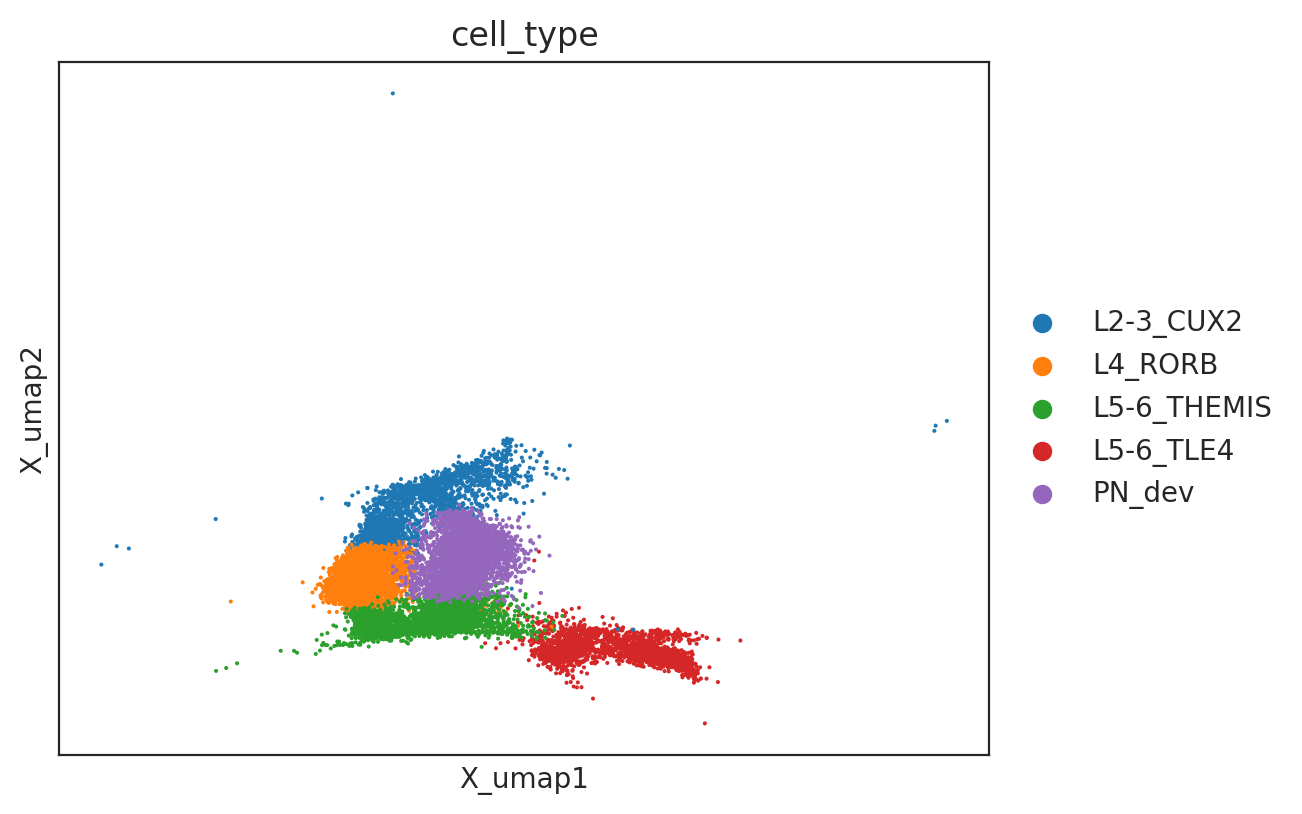

Transition probabilities estimated for the combined simulated data
Embedding shift calculated for the combined simulated data


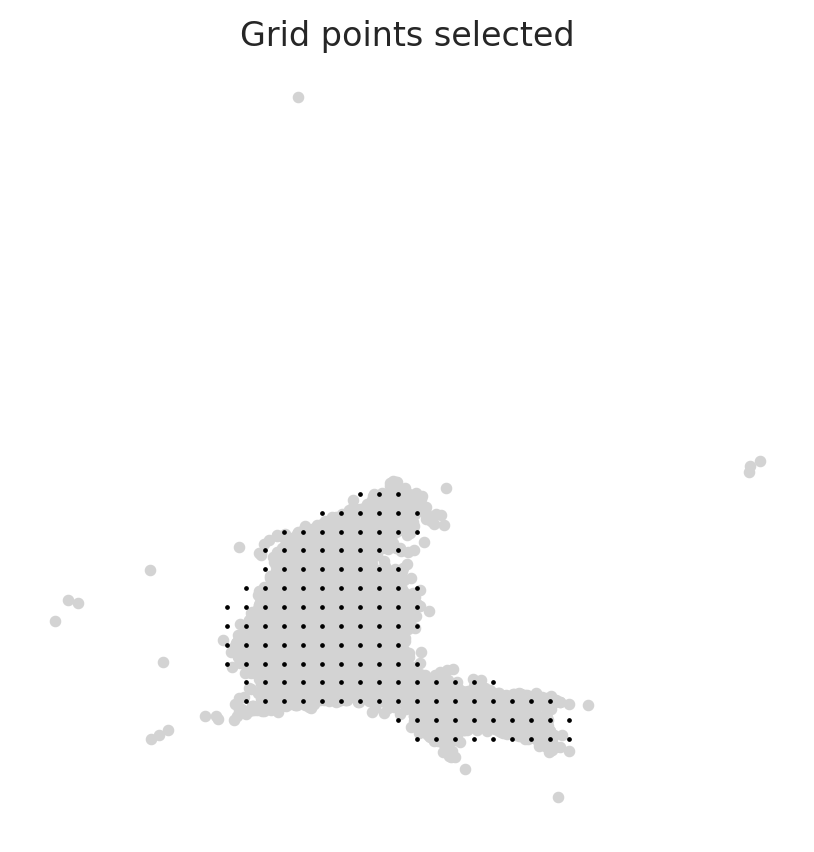

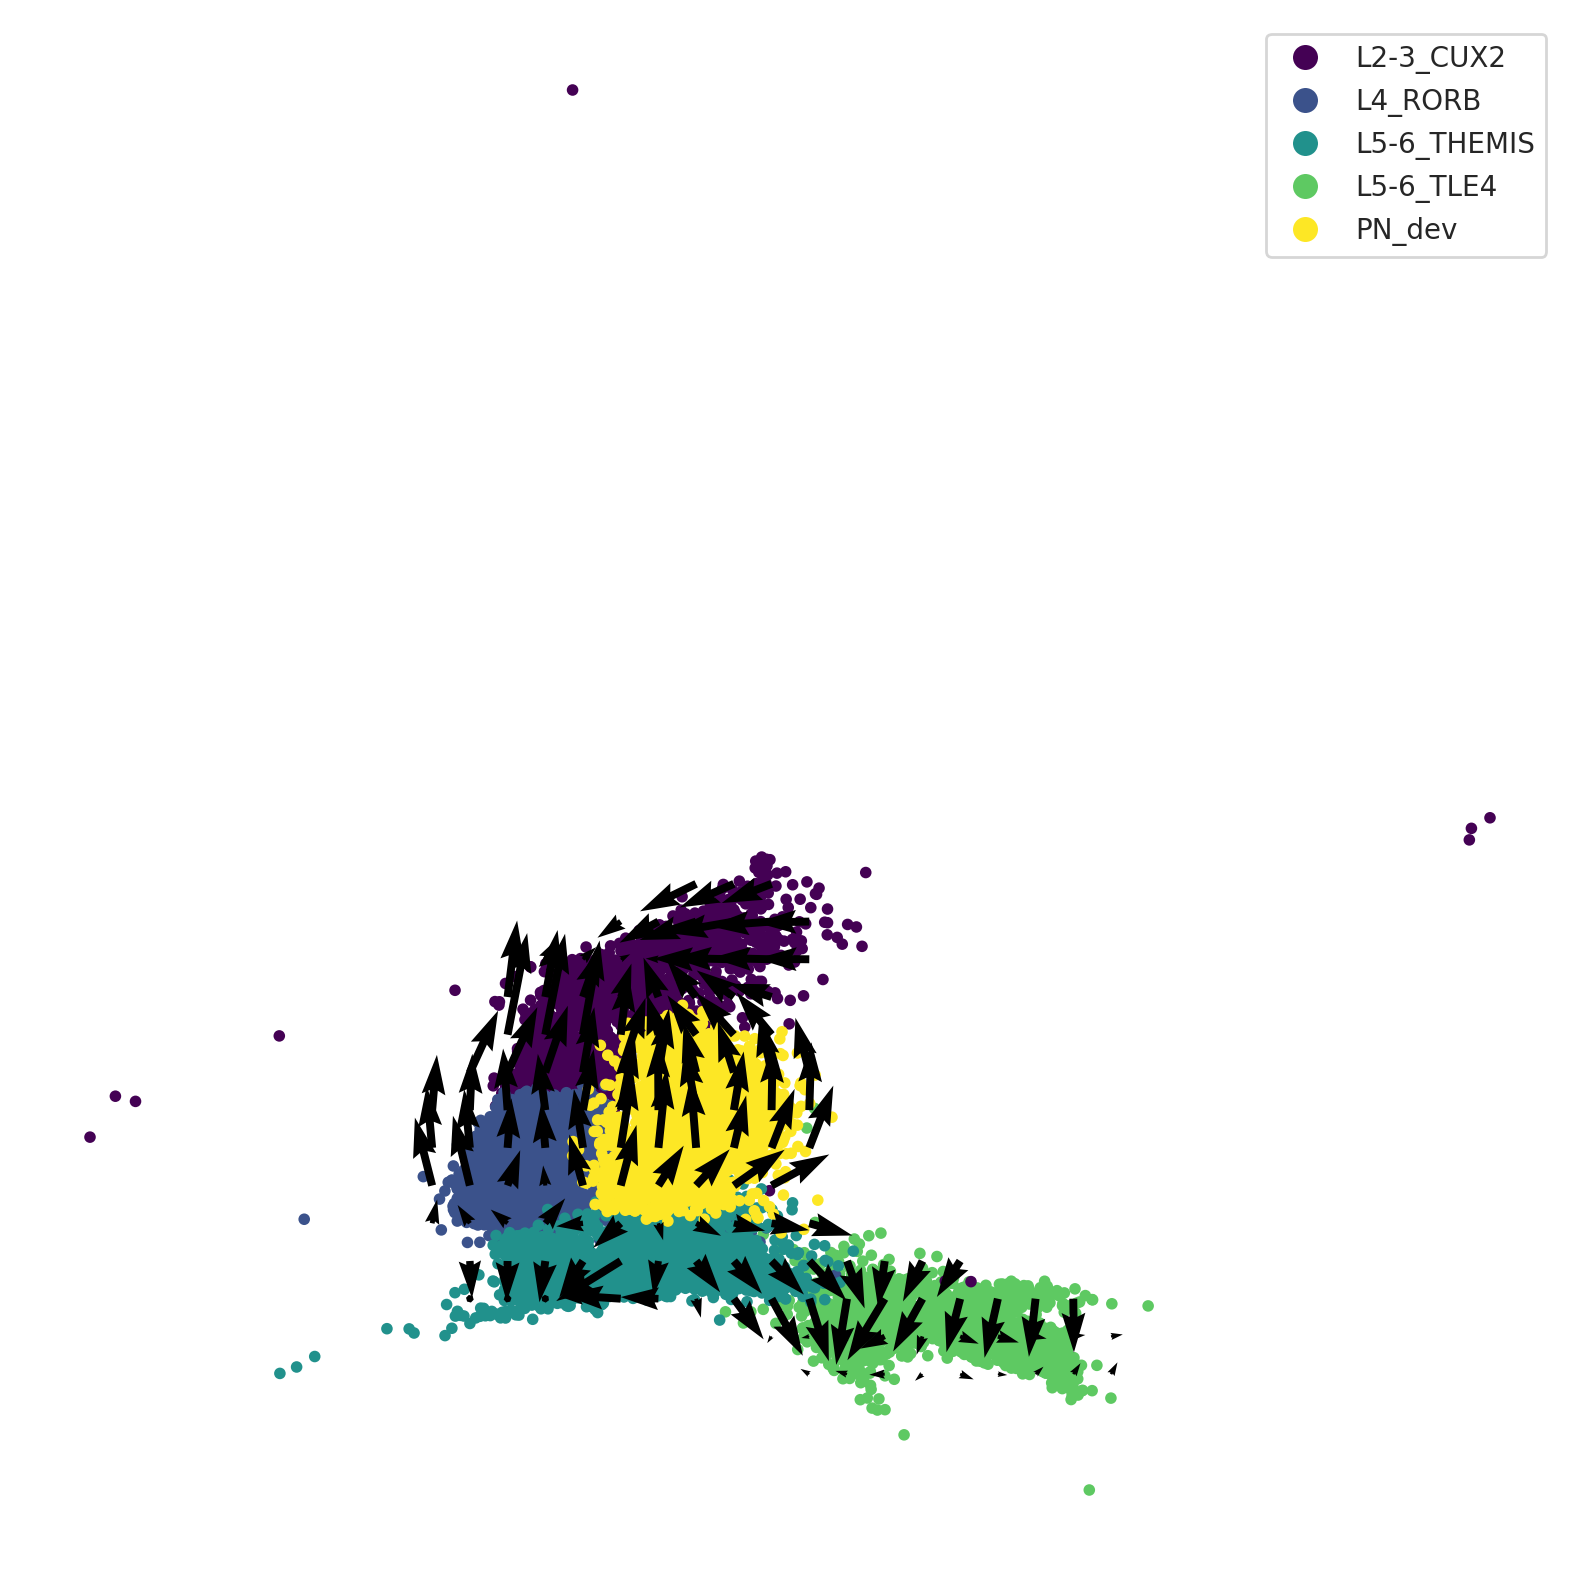

In [ ]:
print(f"Combining simulated data from {len(combined_simulated_data)} cell types")
combined_simulated_adata = sc.concat(combined_simulated_data)

# Create a dictionary to store the original UMAP coordinates for each cell
original_umap_coords = dict(zip(original_adata.obs_names, original_adata.obsm['X_umap']))

# Assign the original UMAP coordinates to the combined_simulated_adata
combined_simulated_adata.obsm['X_umap'] = np.array([original_umap_coords[cell_name] for cell_name in combined_simulated_adata.obs_names])

# Create a new CellOracle instance with the combined simulated data
combined_simulated_oracle = co.Oracle()
combined_simulated_oracle.import_anndata_as_raw_count(combined_simulated_adata,
                                                      cluster_column_name="cell_type",
                                                      embedding_name="X_umap")

# Estimate transition probabilities for the combined simulated data
combined_simulated_oracle.estimate_transition_prob(n_neighbors=200,
                                                   knn_random=True,
                                                   sampled_fraction=1)
print("Transition probabilities estimated for the combined simulated data")

# Calculate the embedding shift for the combined simulated data
combined_simulated_oracle.calculate_embedding_shift(sigma_corr=0.05)
print("Embedding shift calculated for the combined simulated data")

# Calculate p-mass and mass filter for the combined simulated data
n_grid = 40
combined_simulated_oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
min_mass = 60
combined_simulated_oracle.calculate_mass_filter(min_mass=min_mass, plot=False)

# Plot the simulation results using the combined UMAP embedding and perturbation scores
plot_arrows_legend(combined_simulated_oracle, labels='cell_type', scale=10, data_random=False, points_size=10,
                   filename=os.path.join(output_dir, f"v1_combined_simulation_flow_on_grid_{goi}.png"))

# Single clusters

THRB is a regulatory gene in the base GRN for cell type L5-6_TLE4


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for L5-6_TLE4...


  0%|          | 0/938 [00:00<?, ?it/s]

THRB is a regulatory gene in the base GRN for cell type L2-3_CUX2


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for L2-3_CUX2...


  0%|          | 0/1232 [00:00<?, ?it/s]

THRB is a regulatory gene in the base GRN for cell type L4_RORB


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for L4_RORB...


  0%|          | 0/1291 [00:00<?, ?it/s]

THRB is a regulatory gene in the base GRN for cell type L5-6_THEMIS


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for L5-6_THEMIS...


  0%|          | 0/1074 [00:00<?, ?it/s]

THRB is a regulatory gene in the base GRN for cell type PN_dev


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for PN_dev...


  0%|          | 0/1284 [00:00<?, ?it/s]

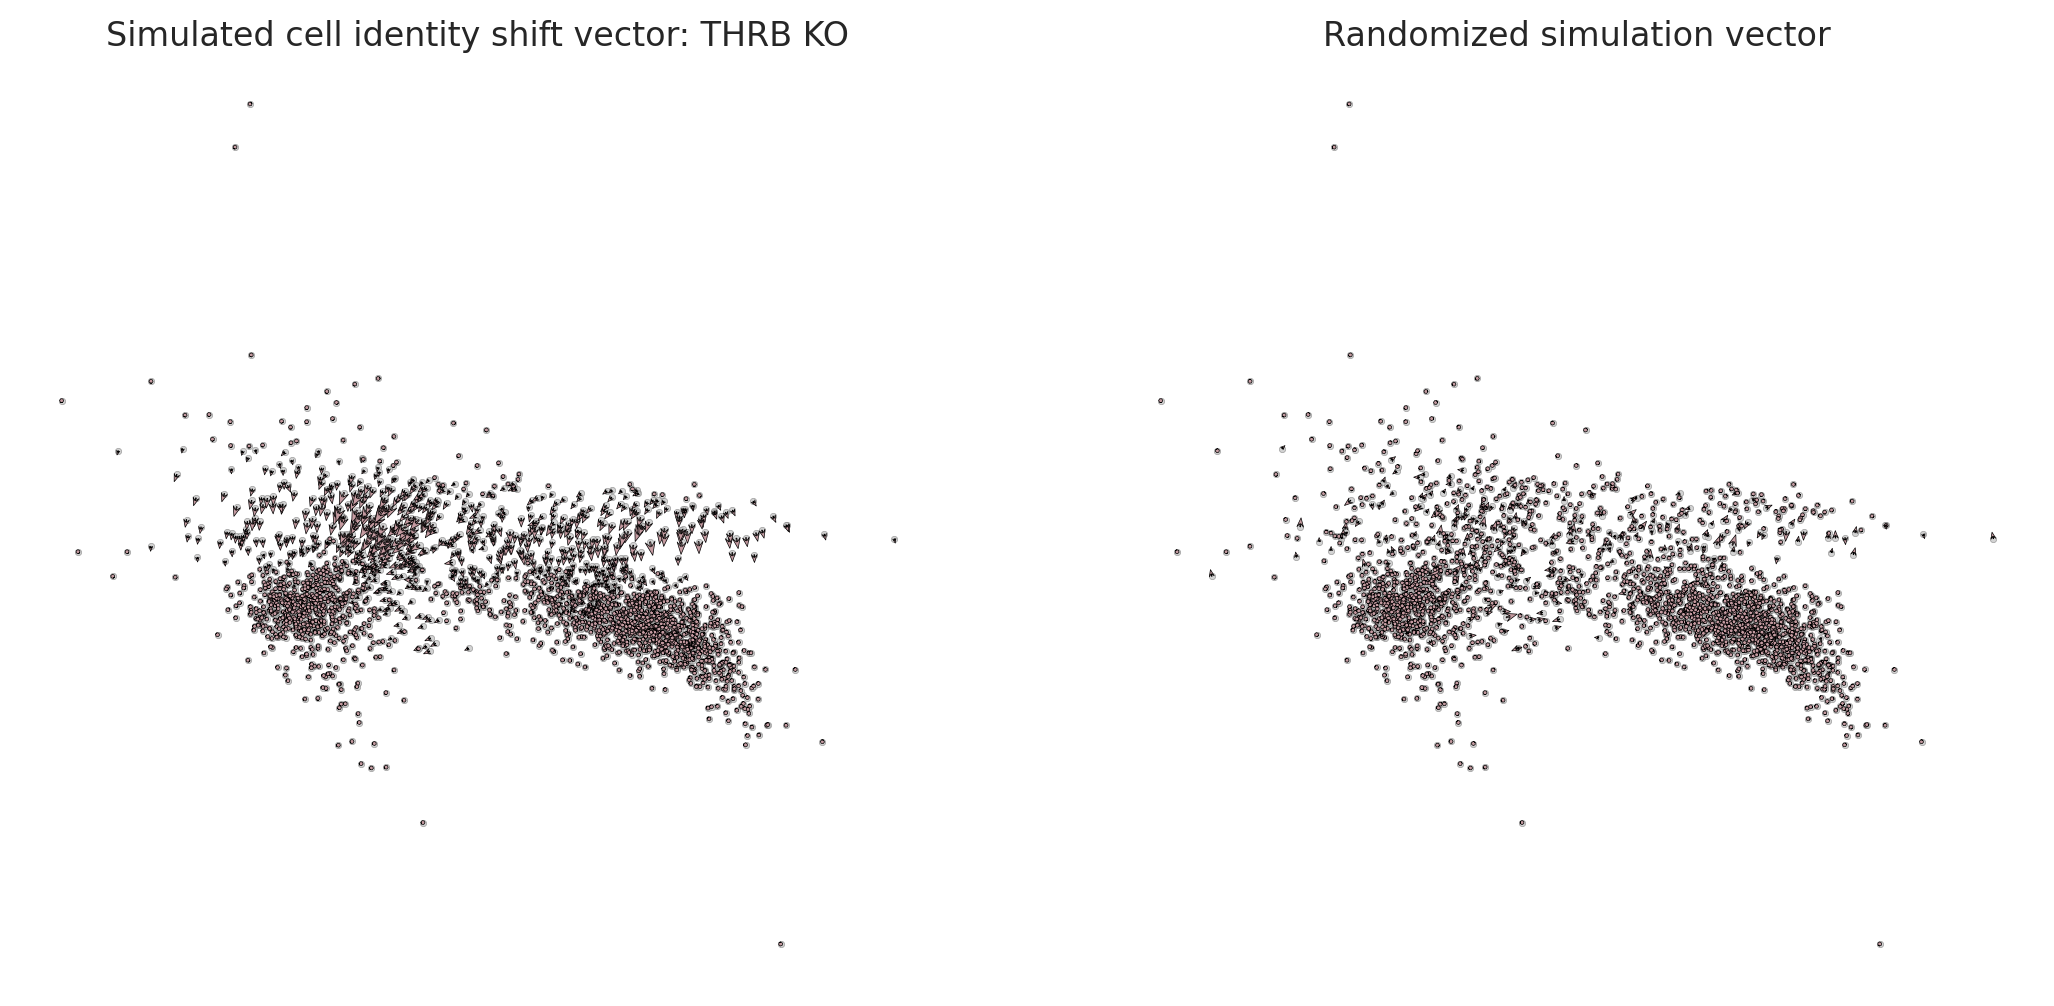

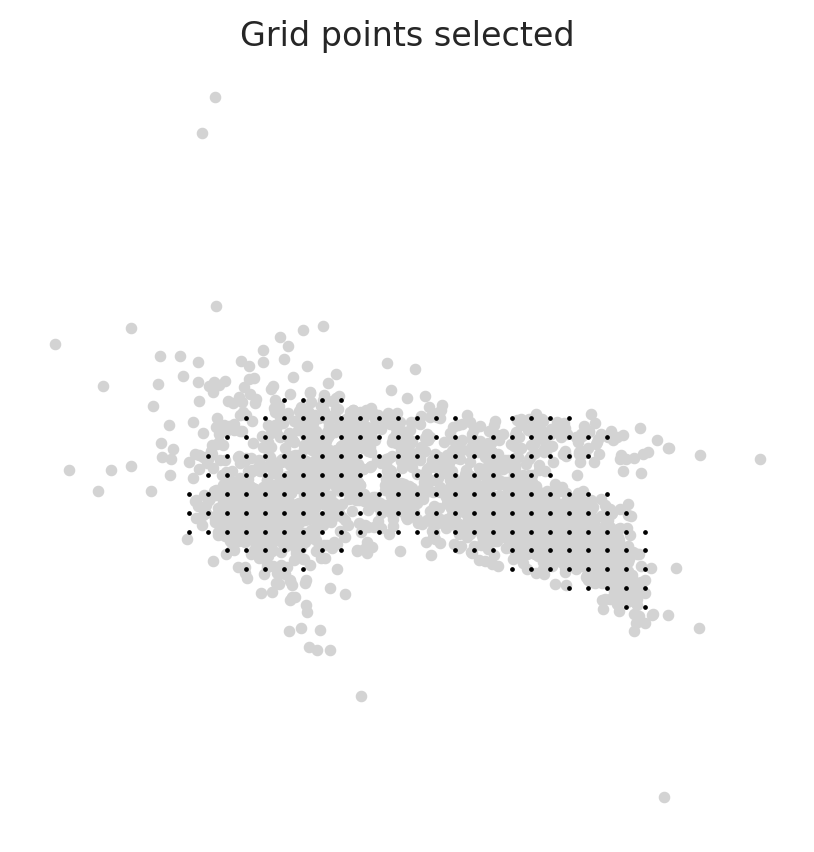

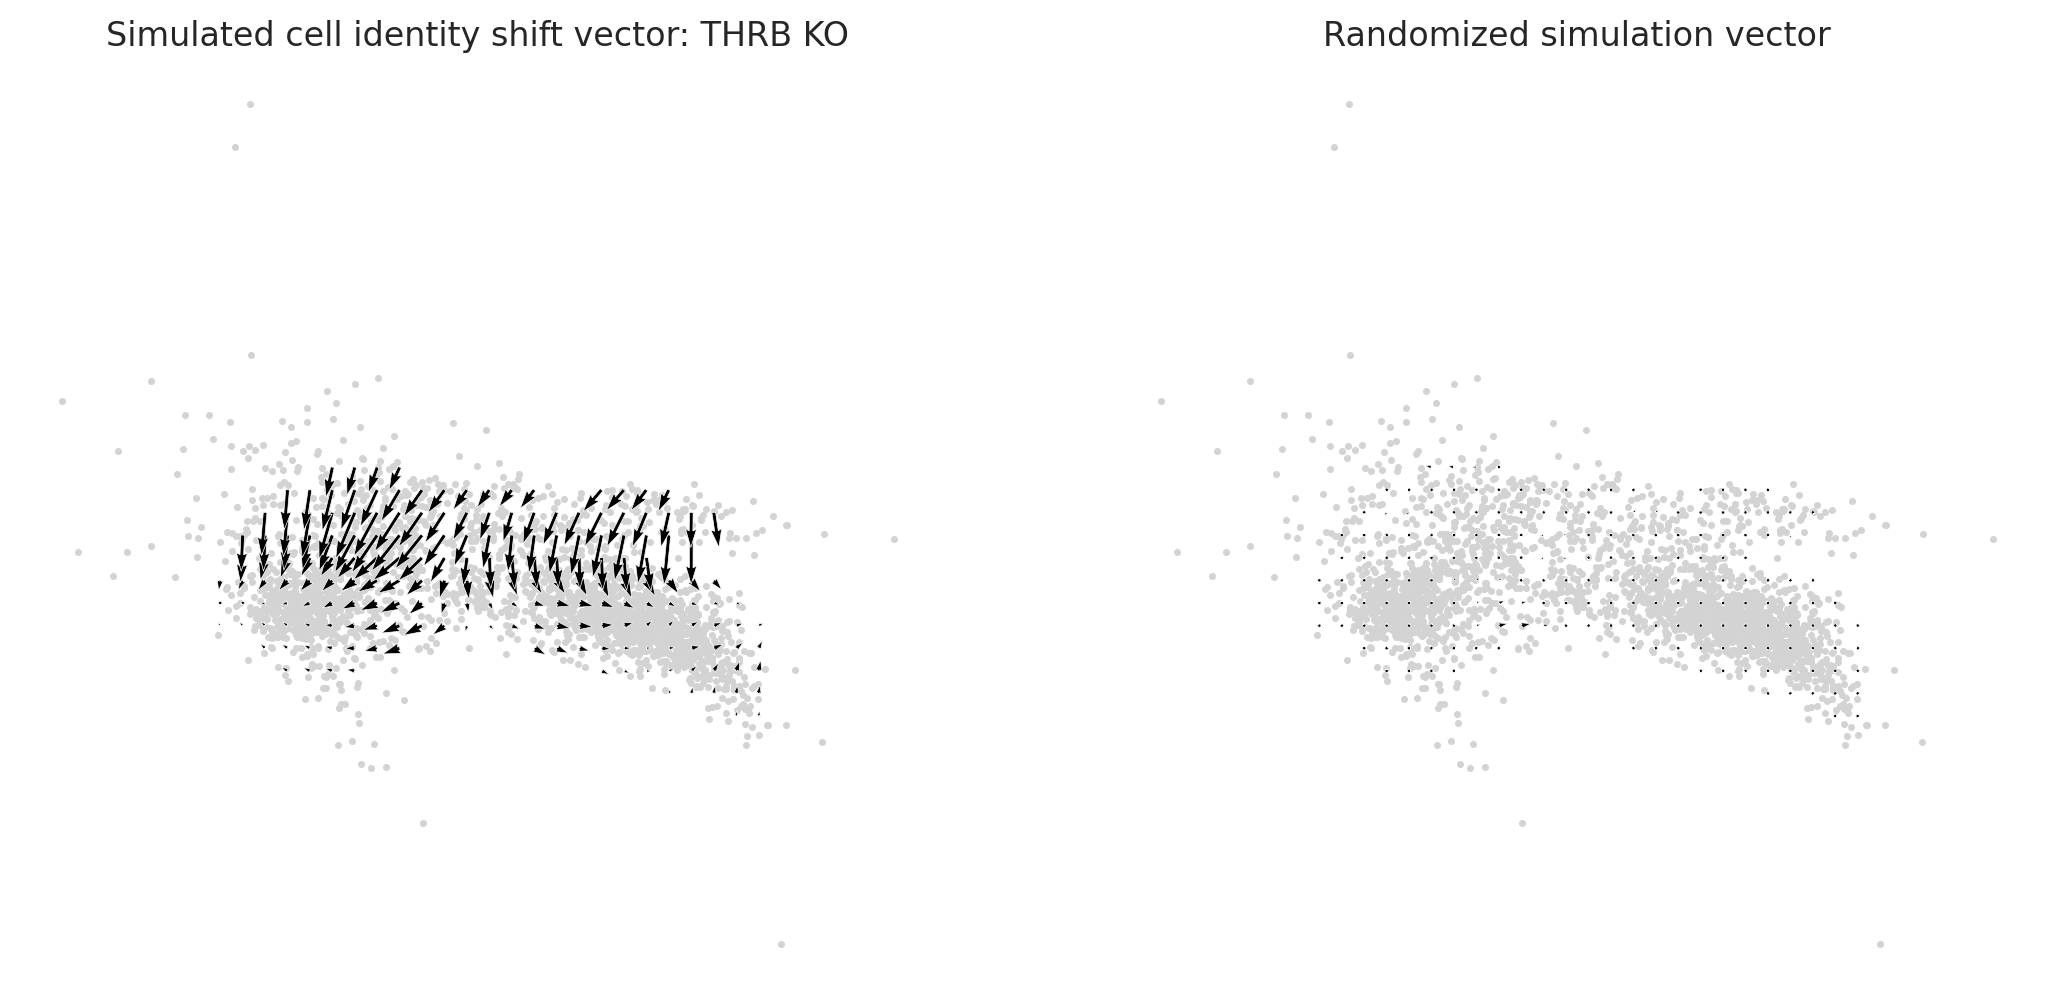

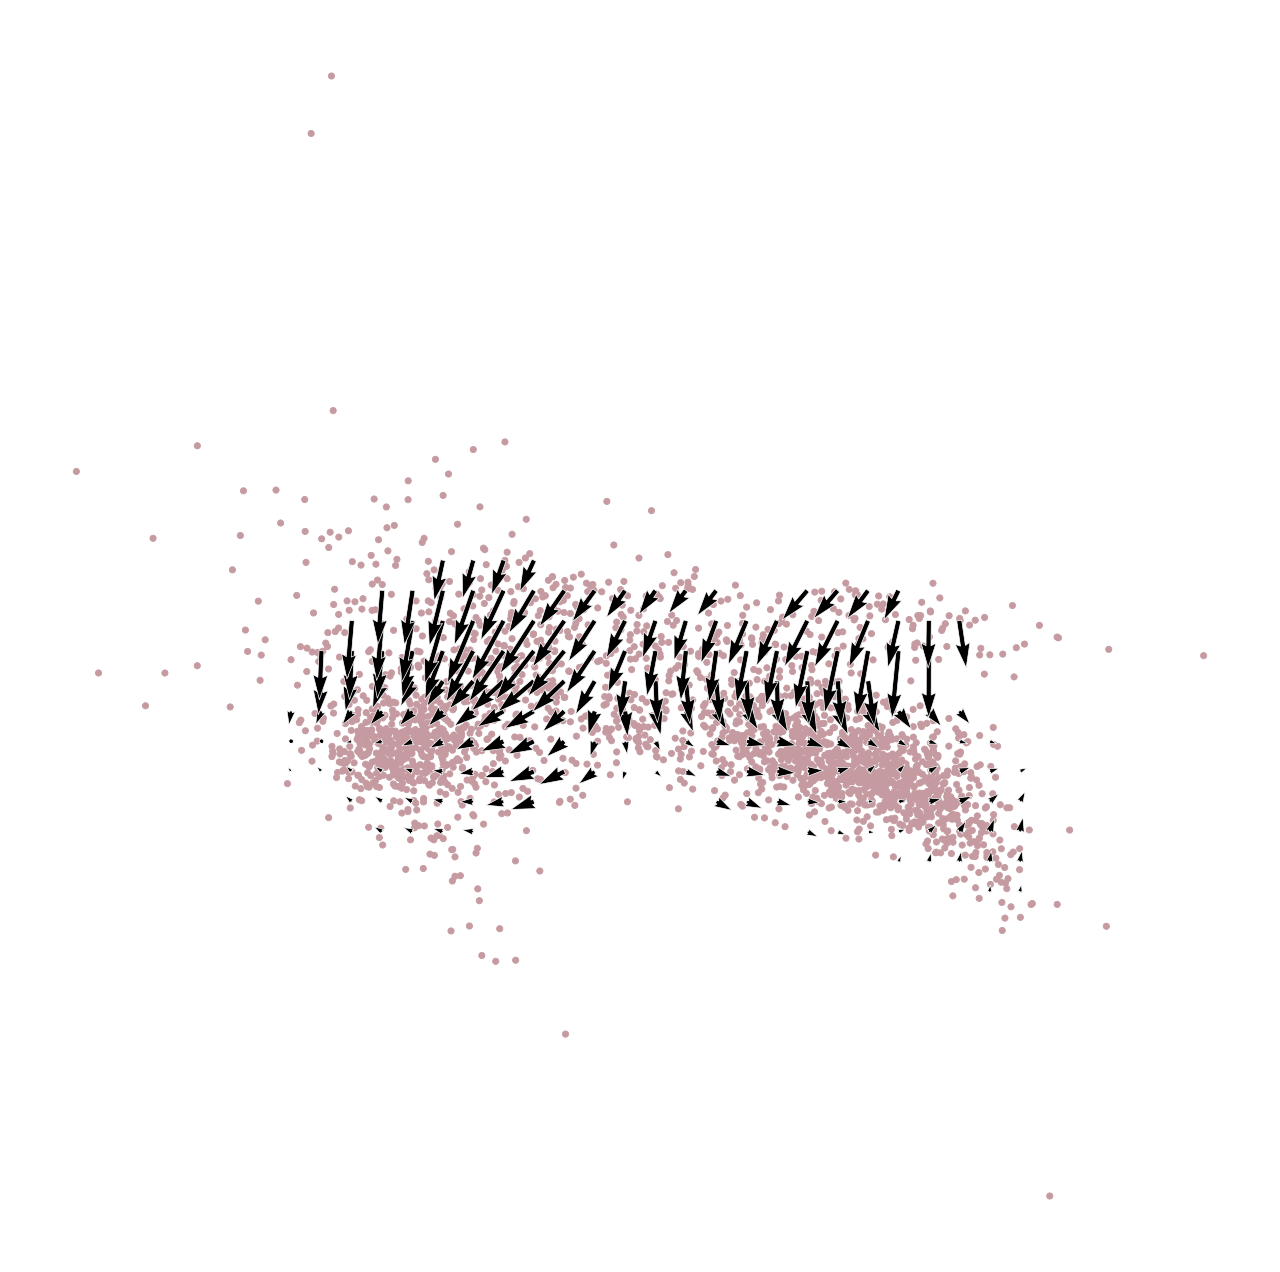

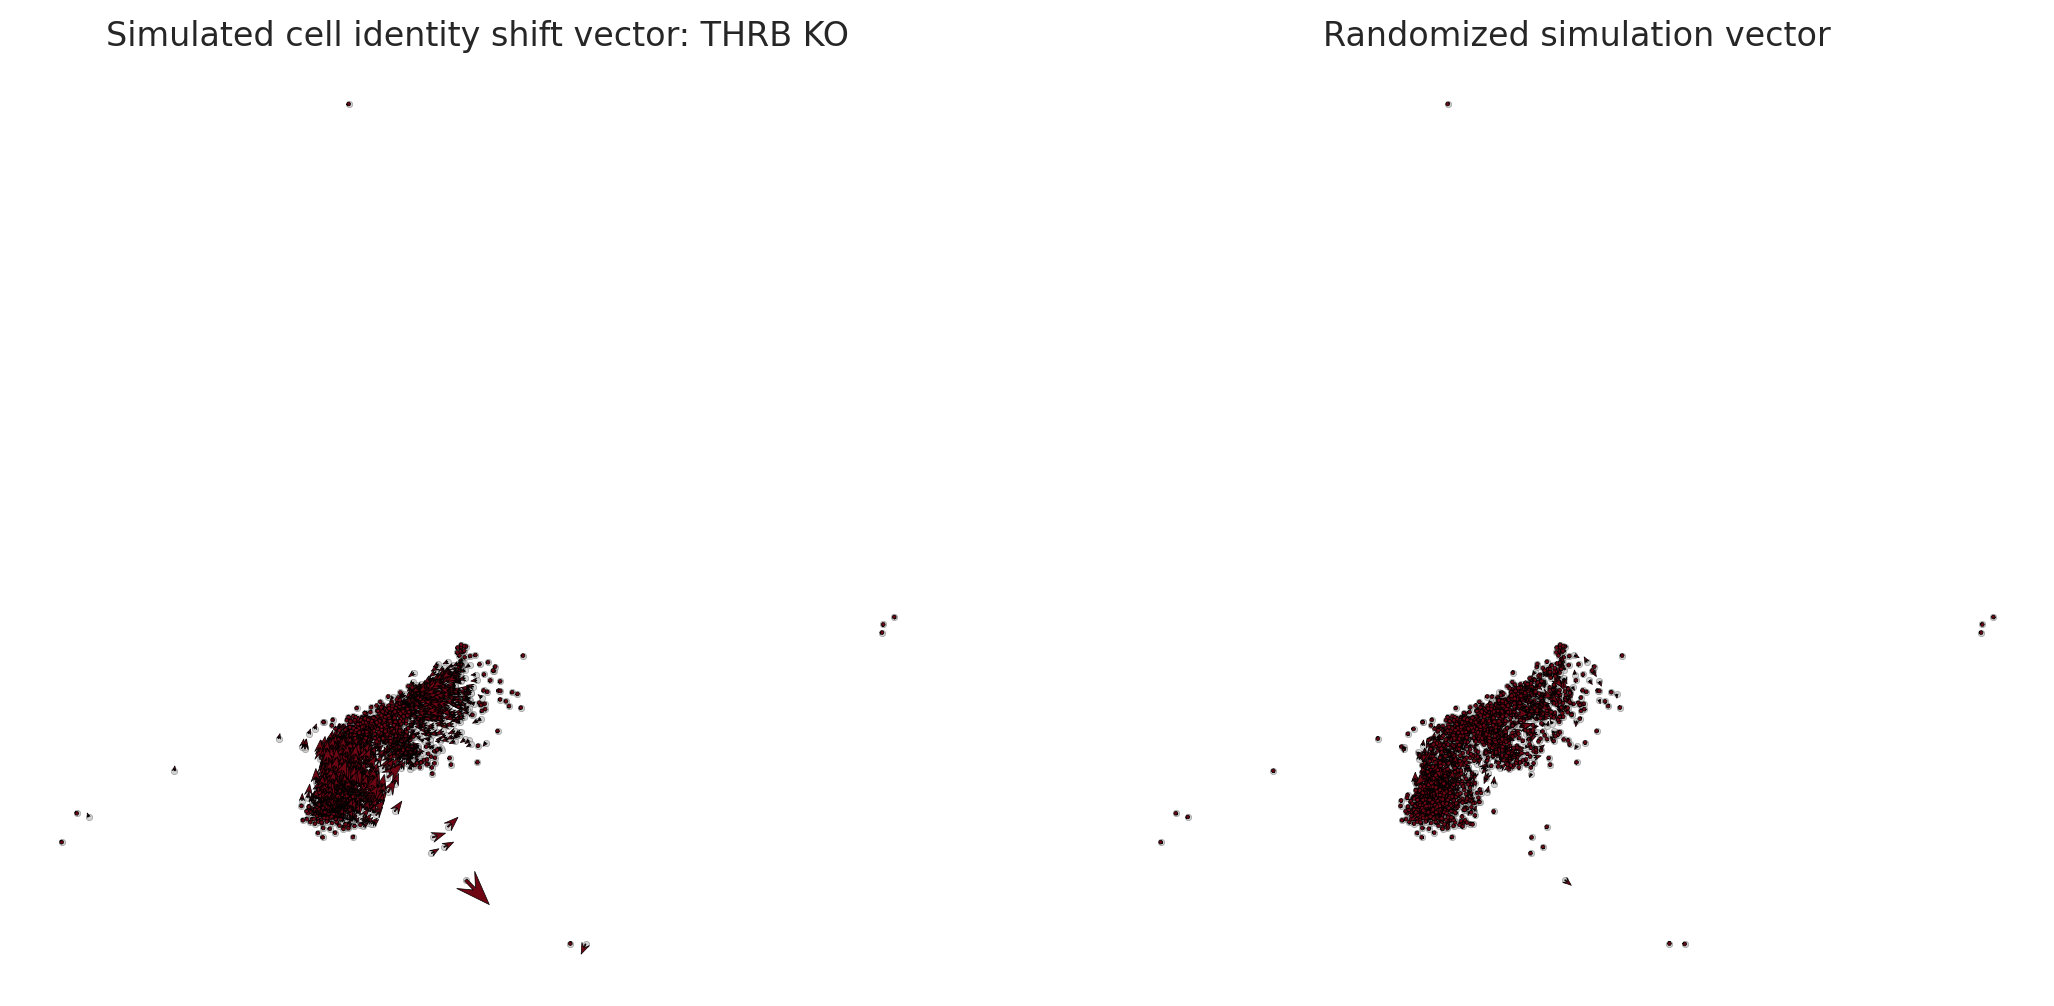

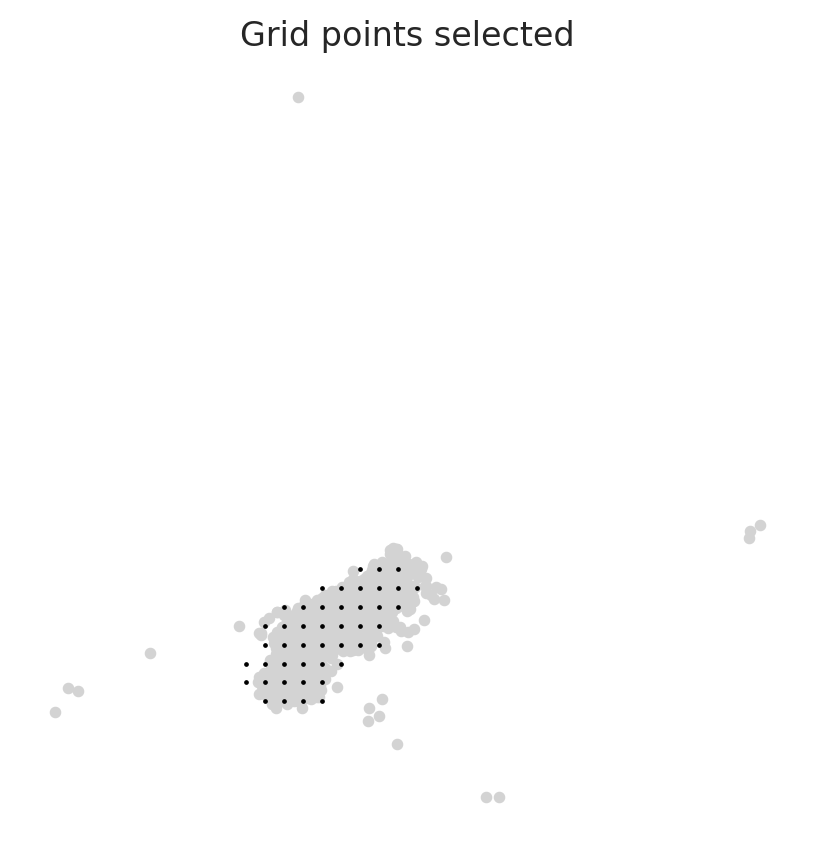

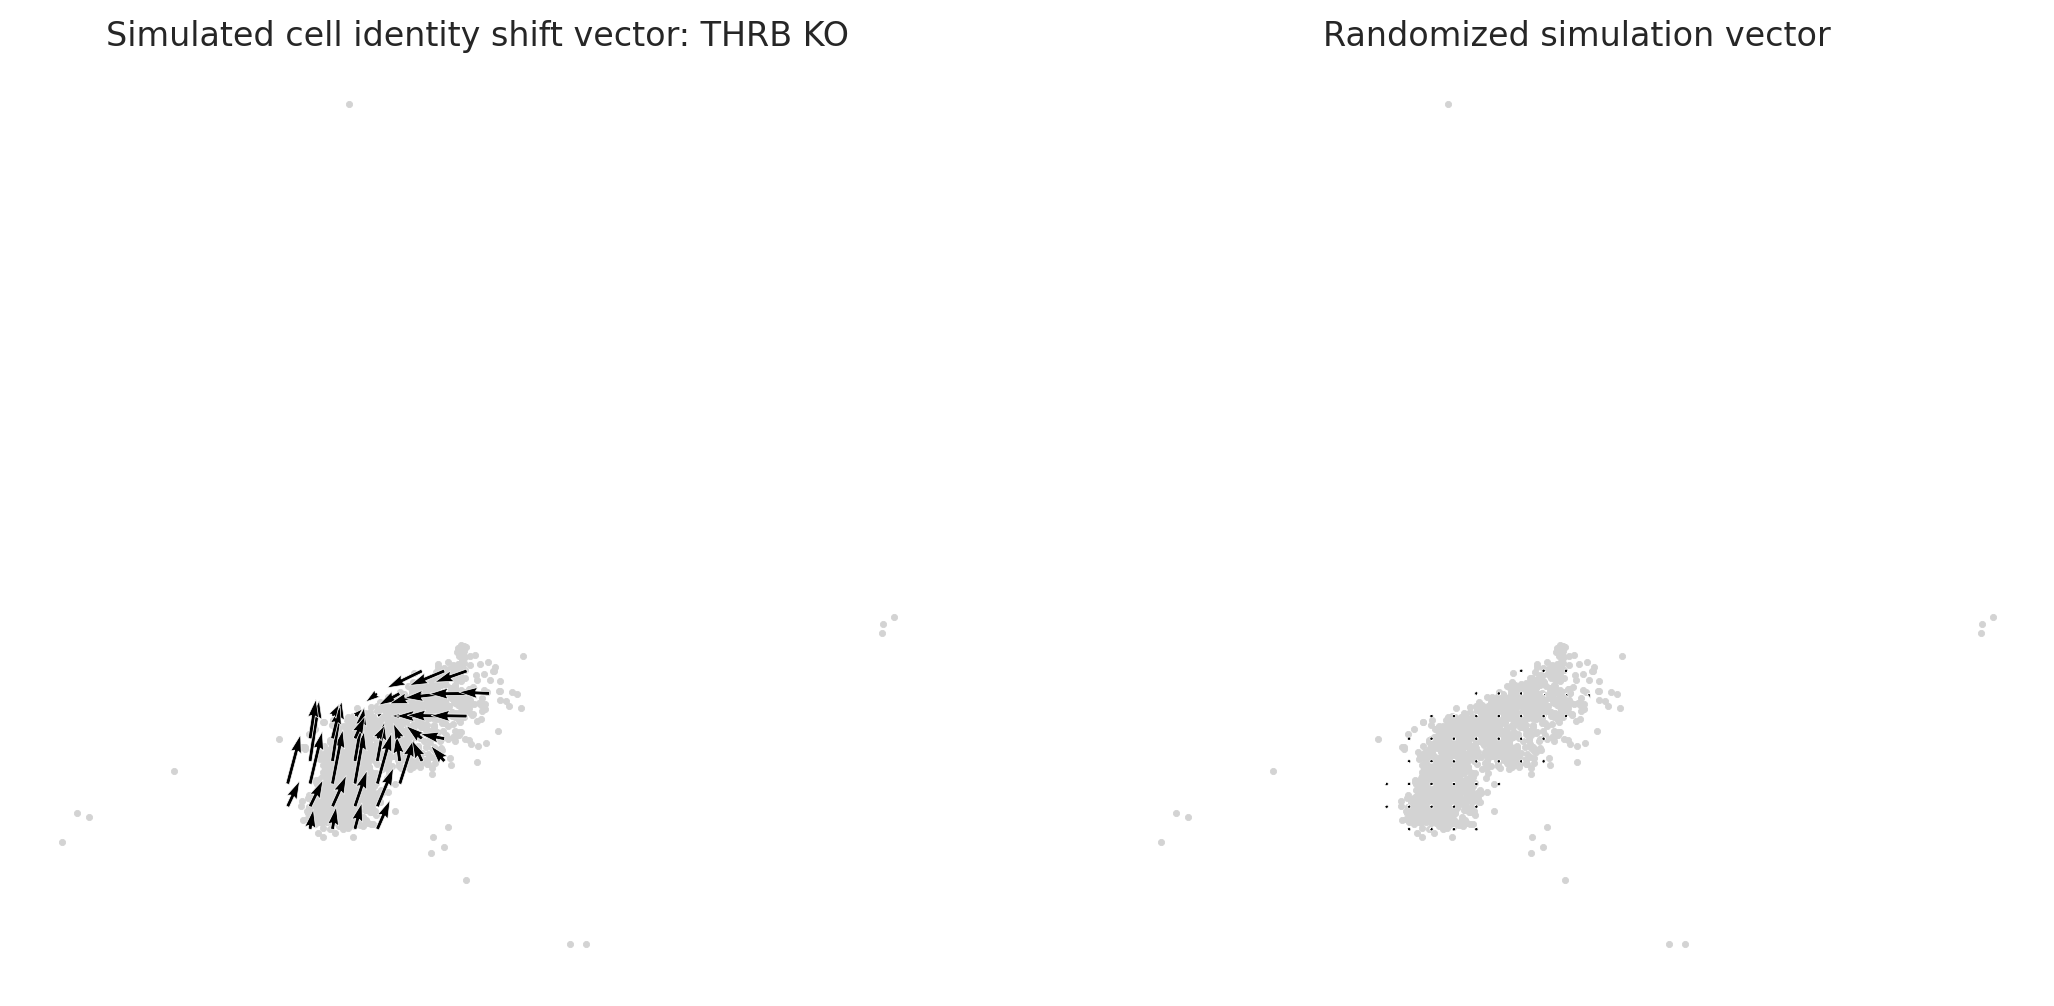

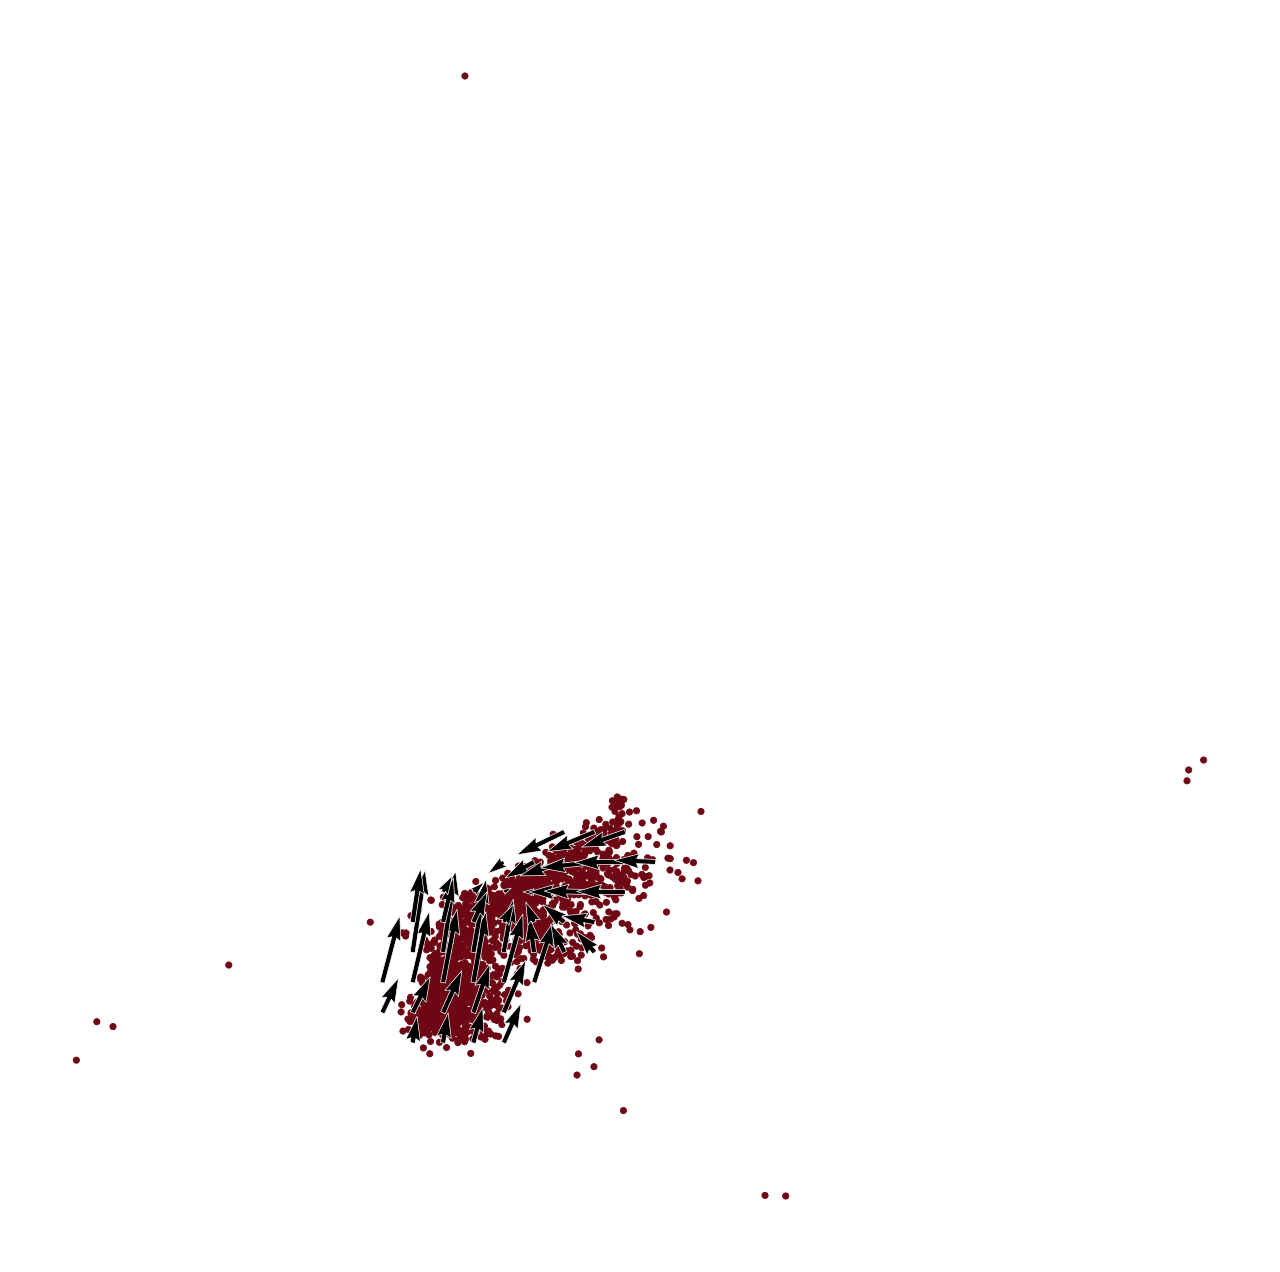

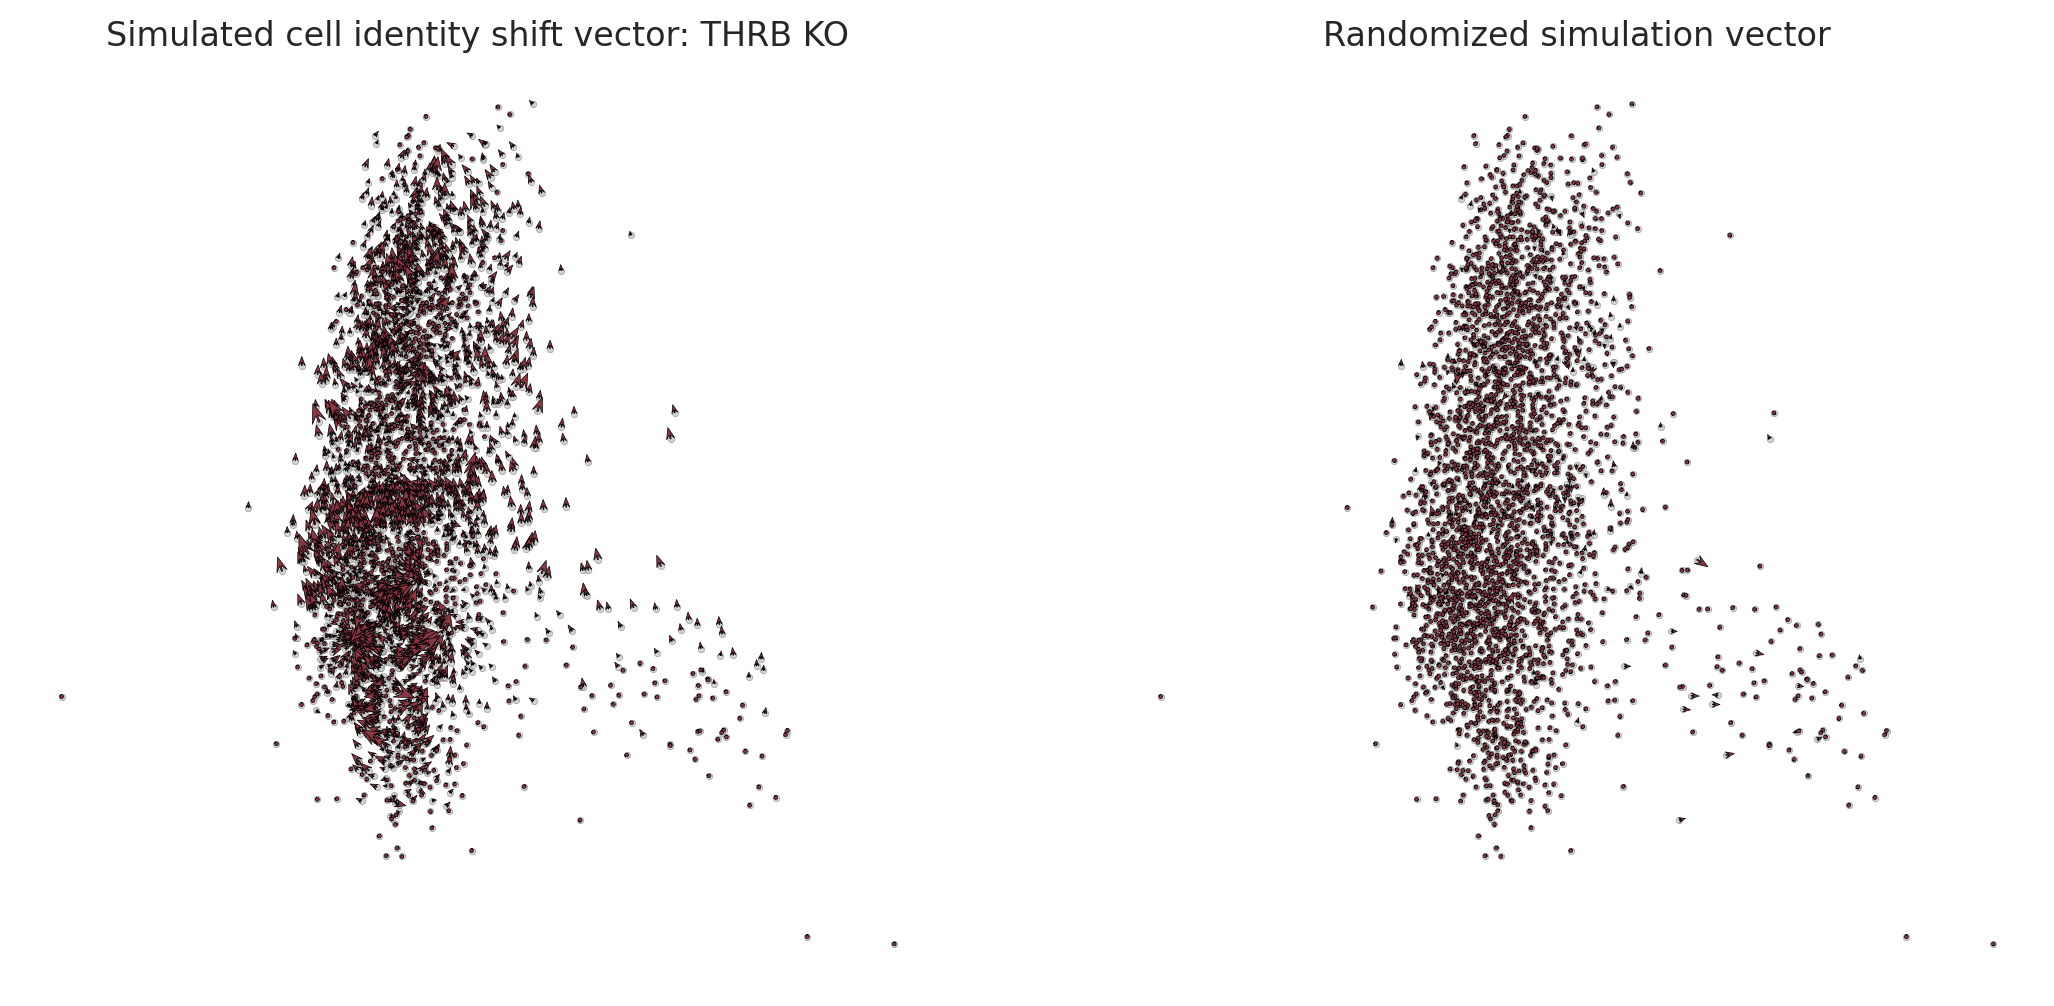

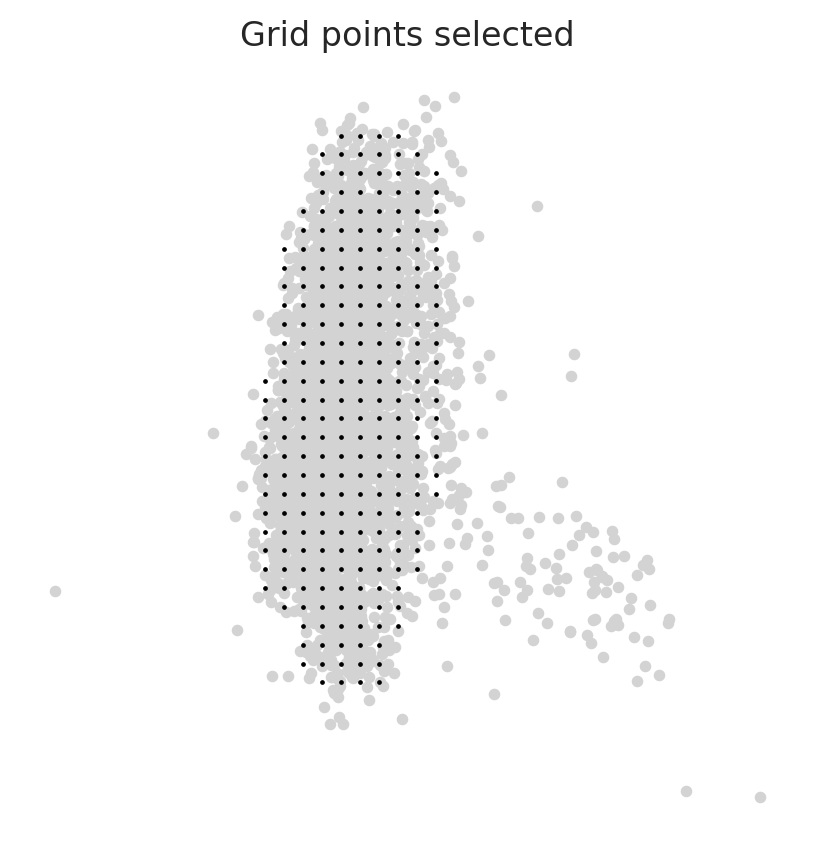

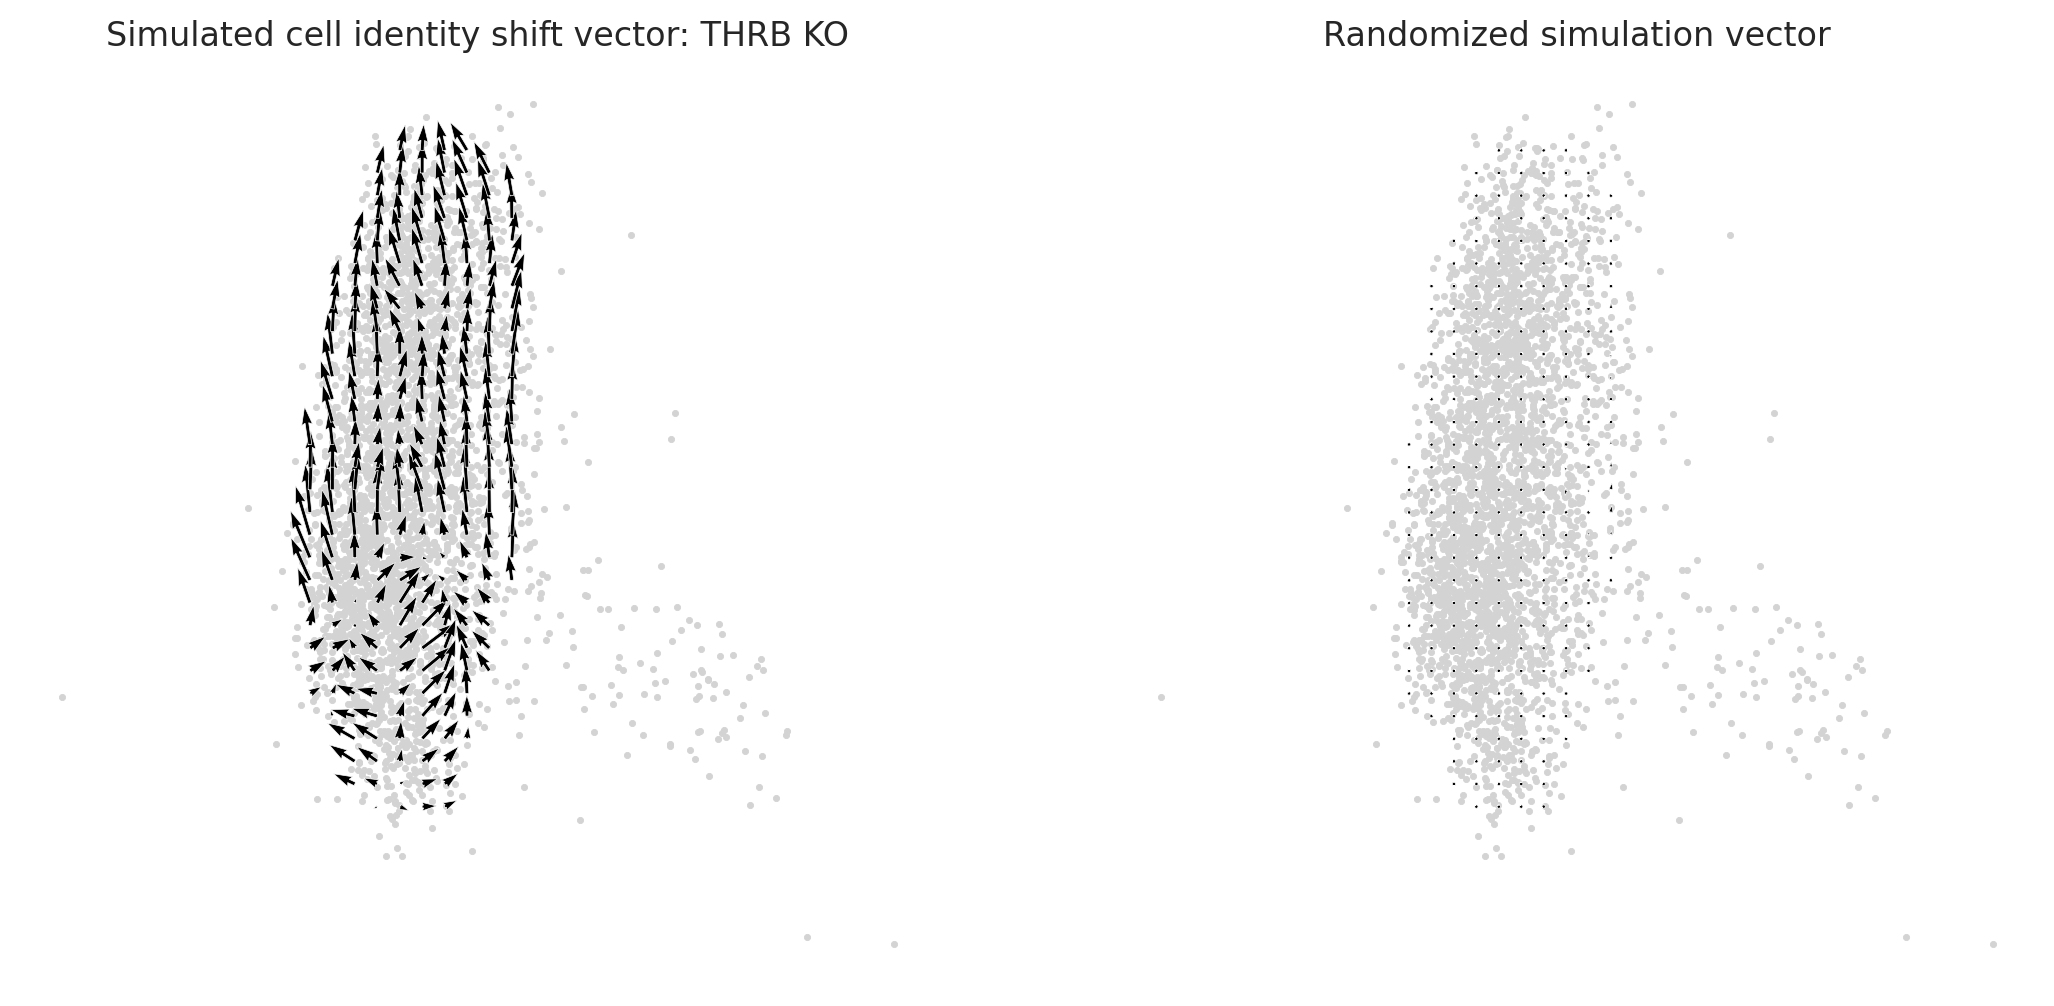

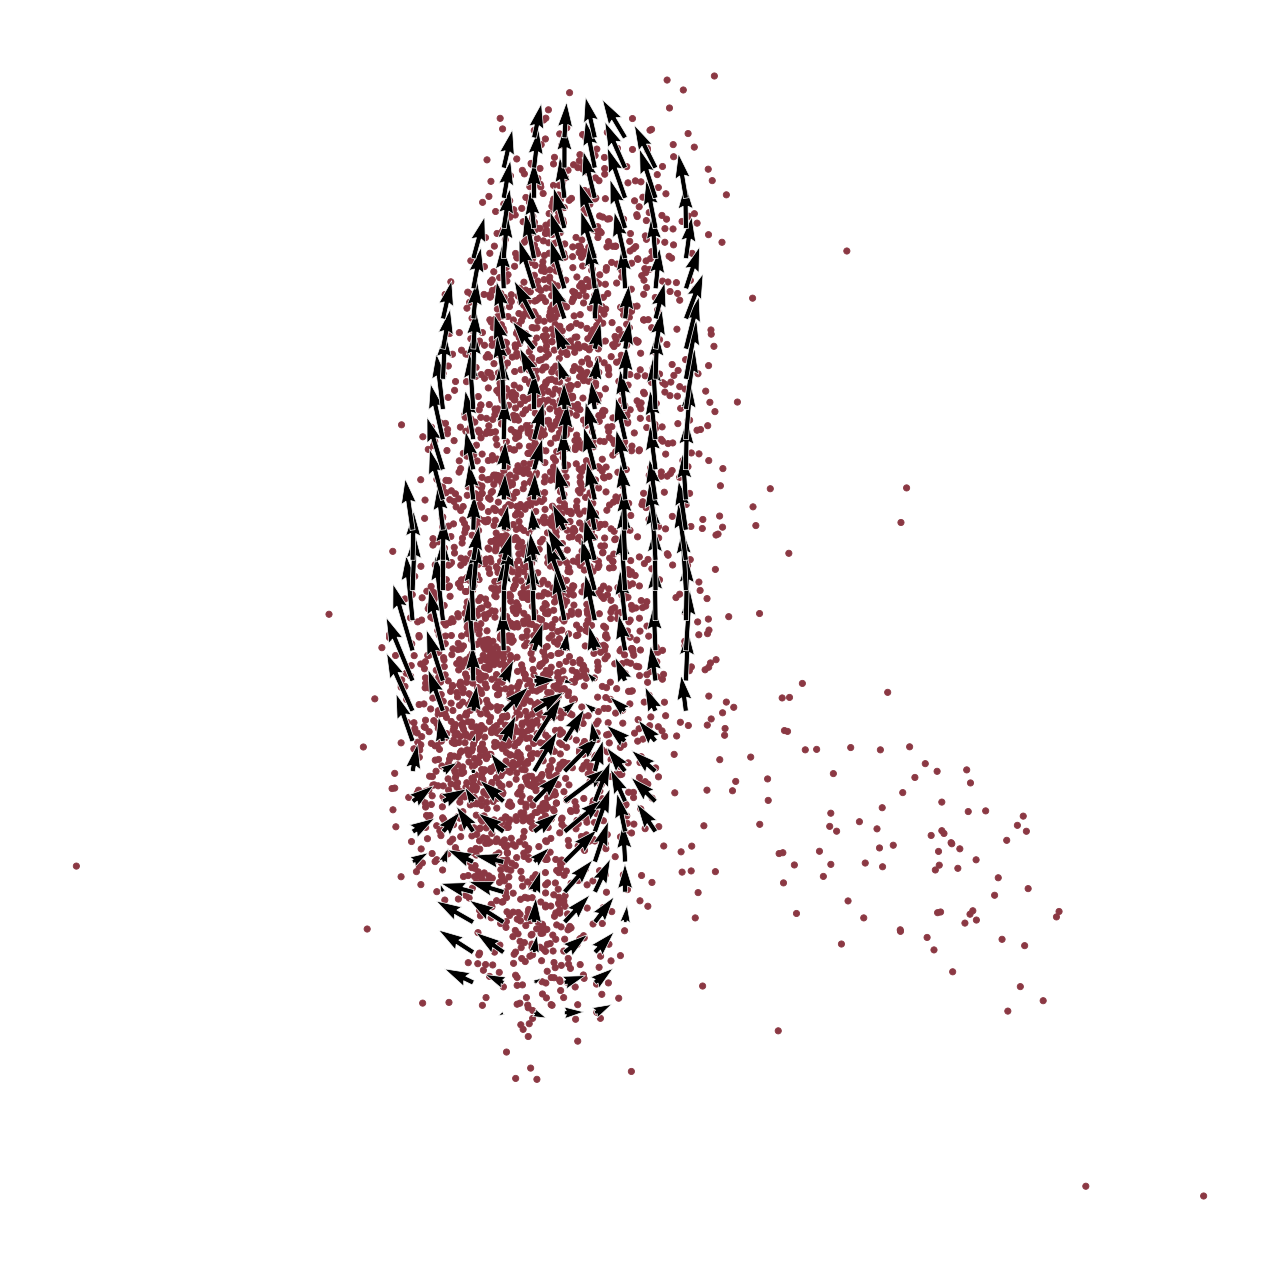

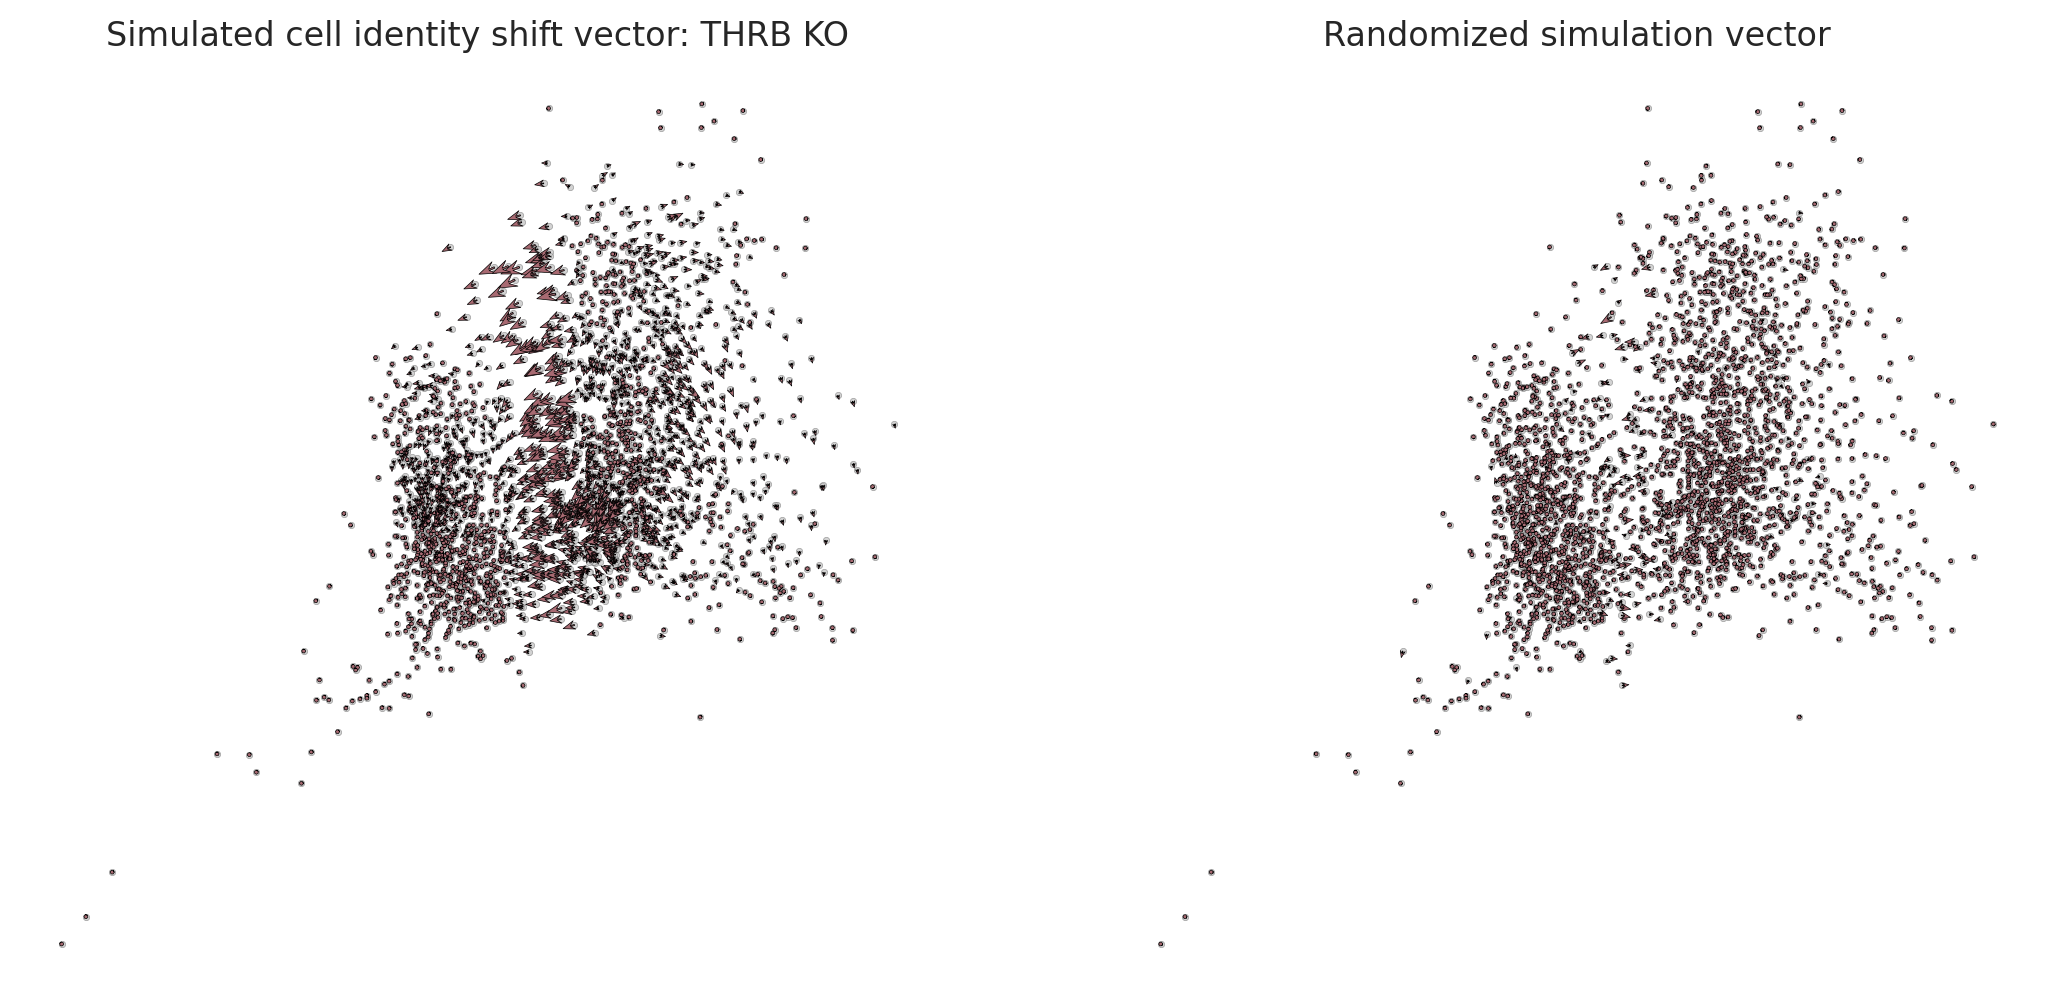

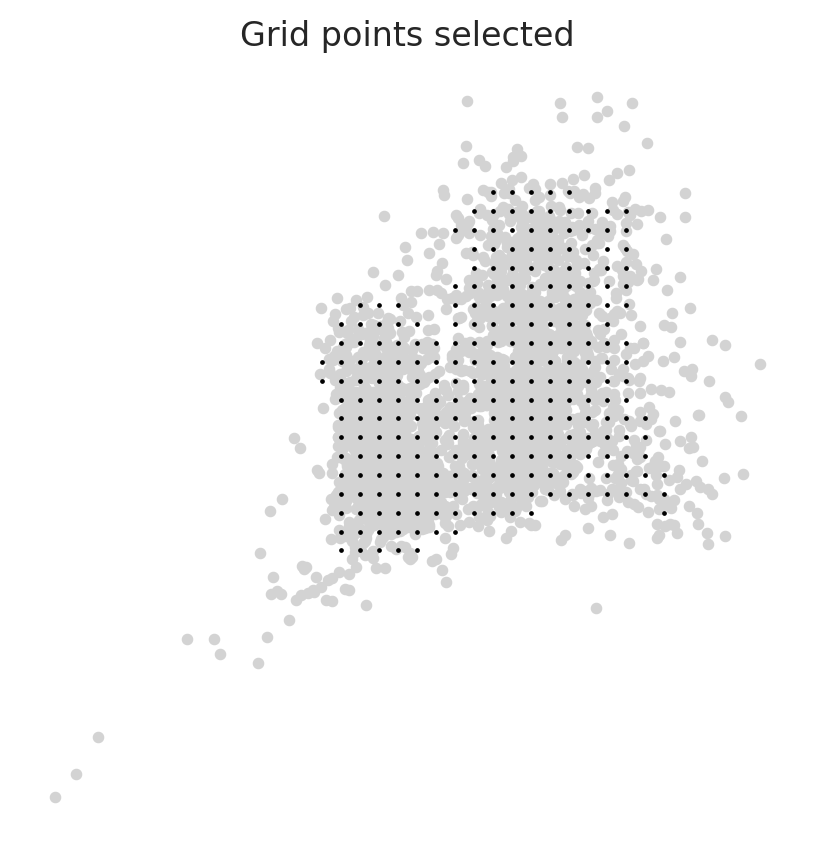

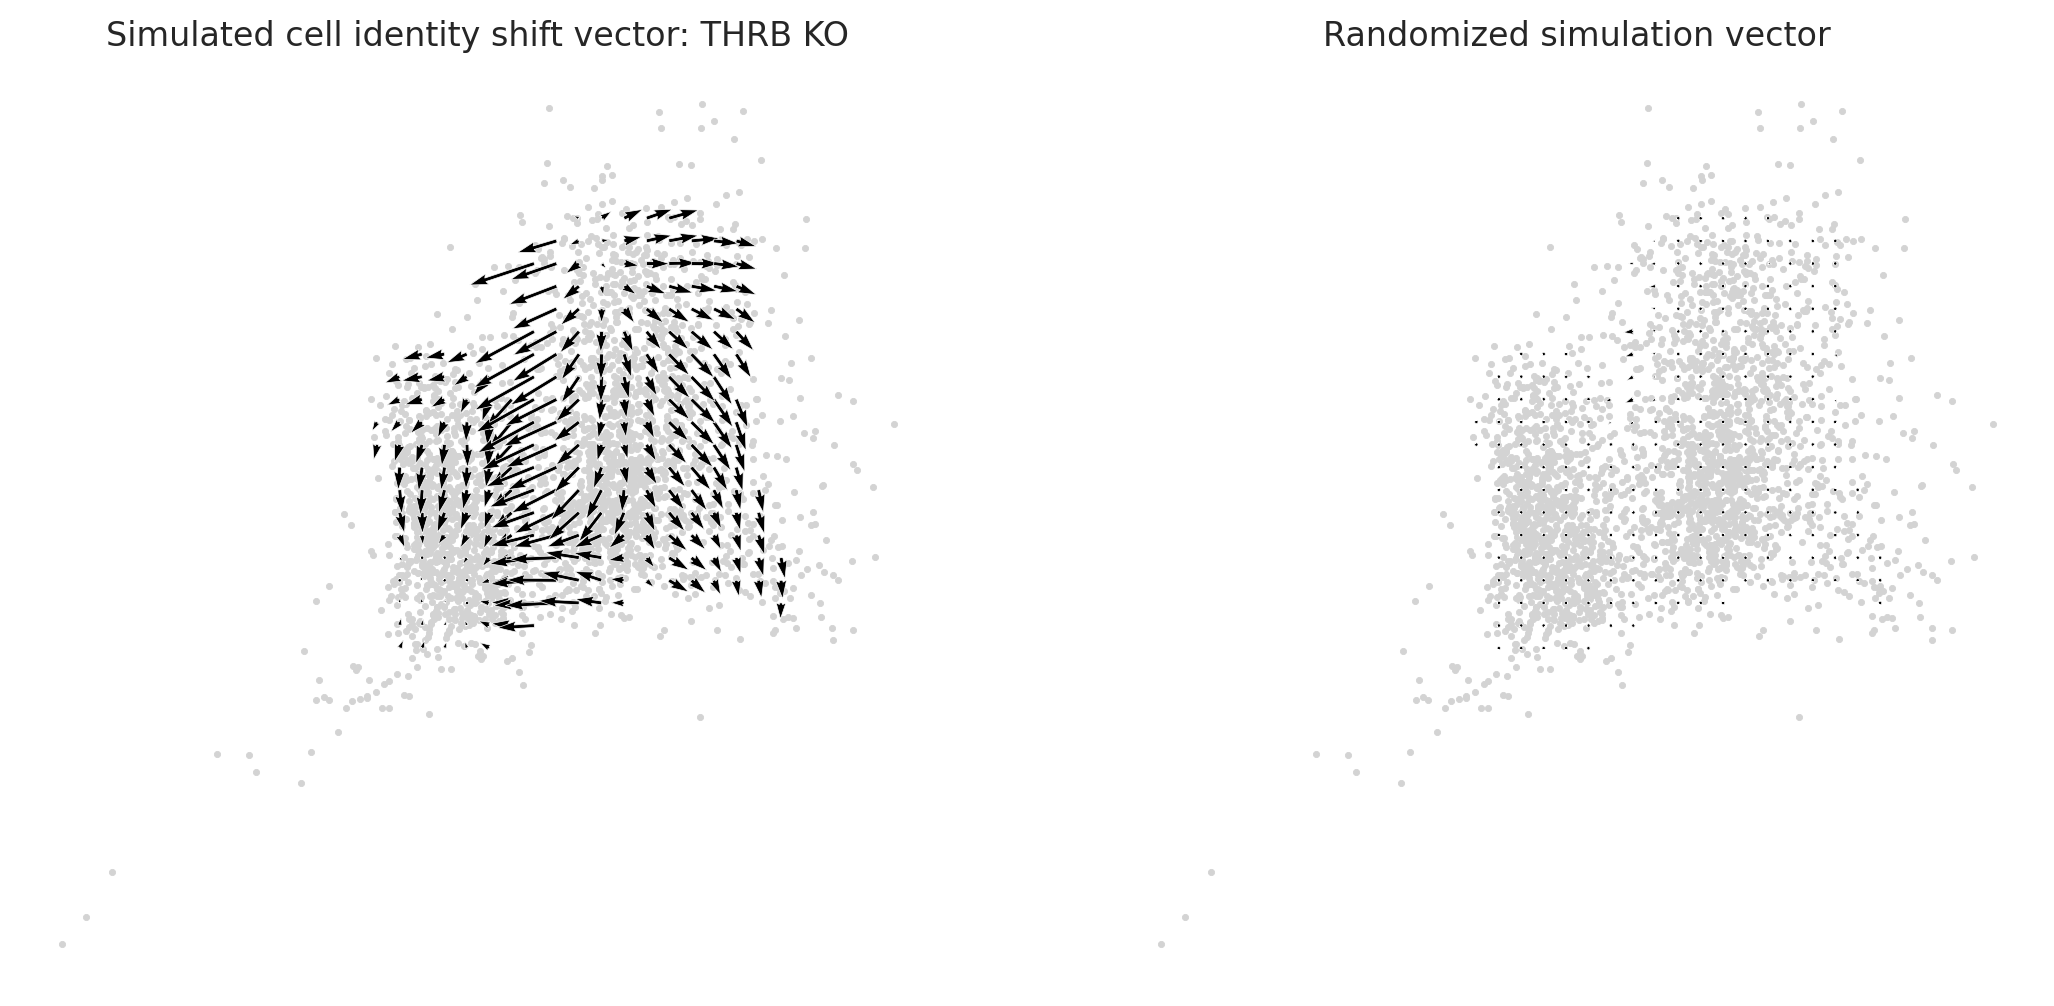

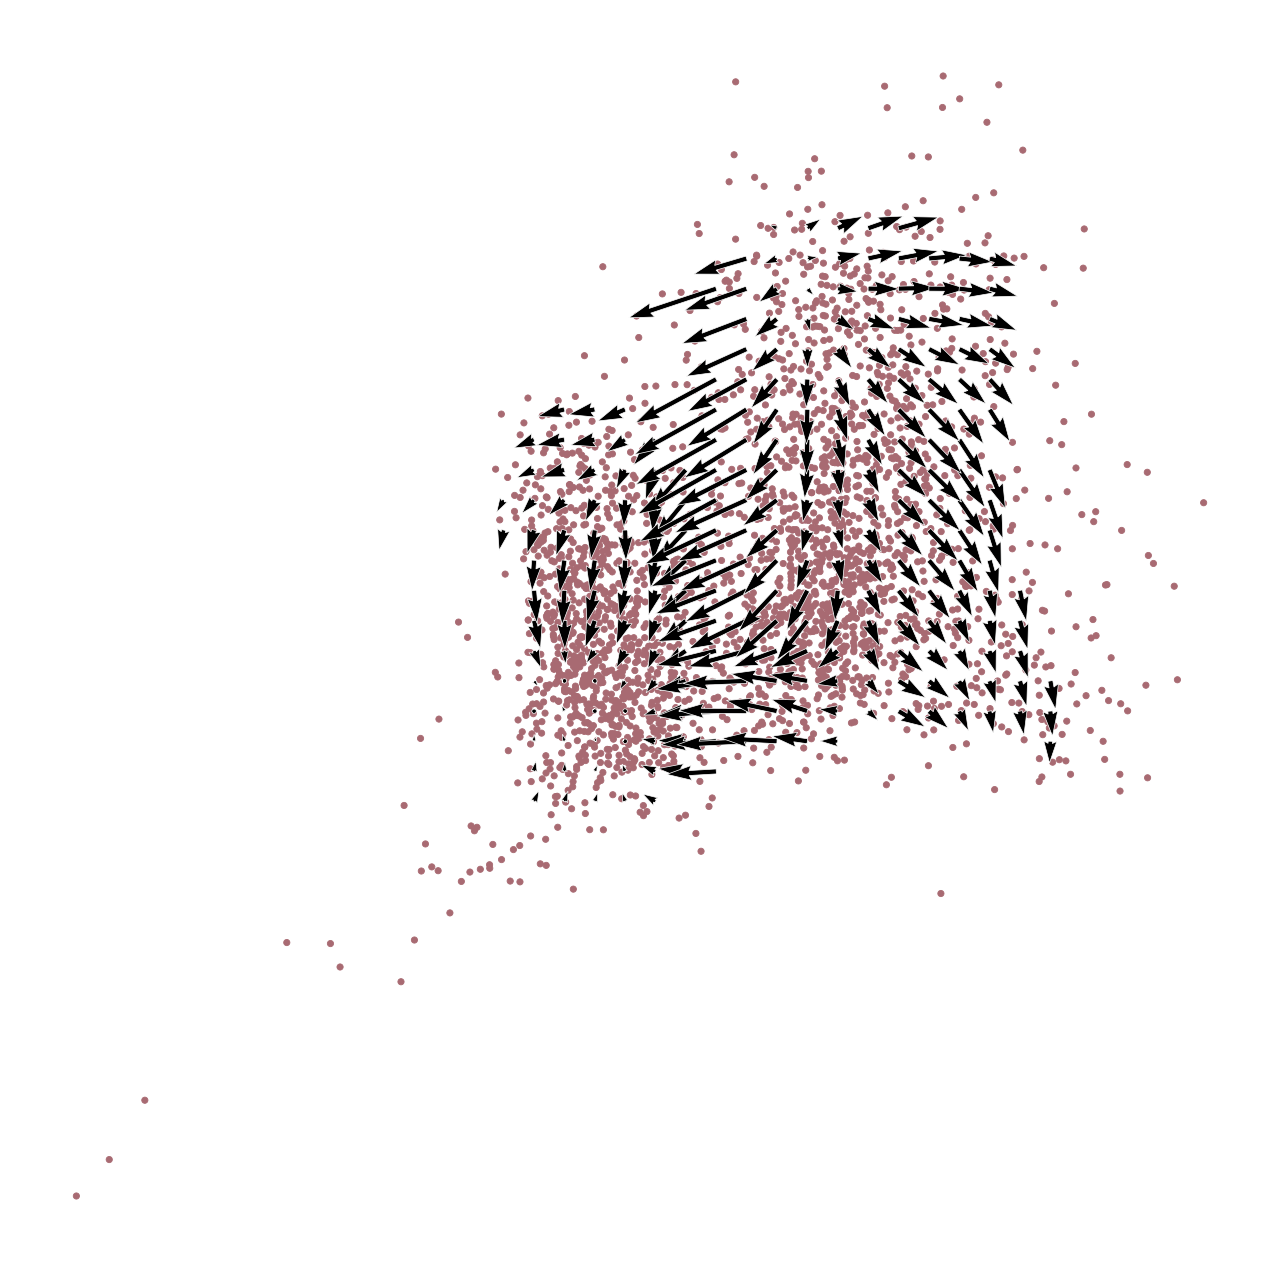

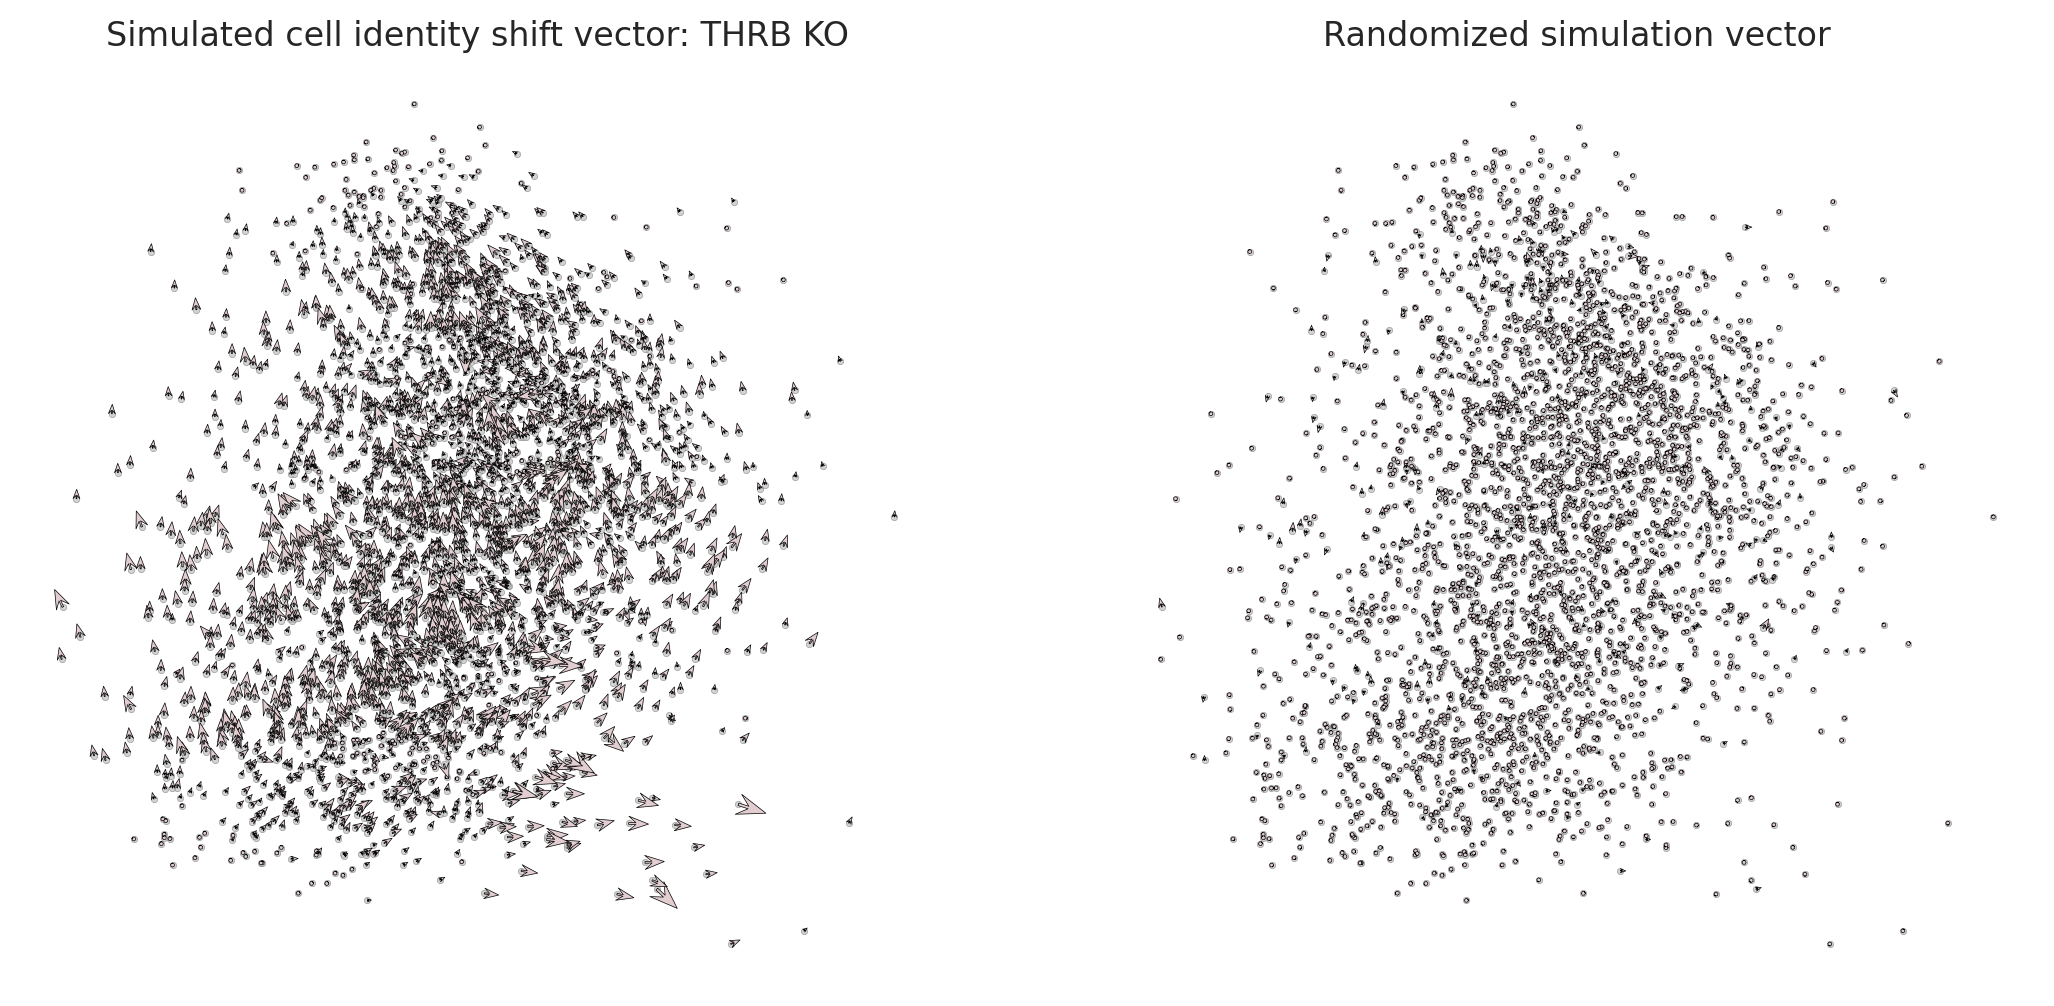

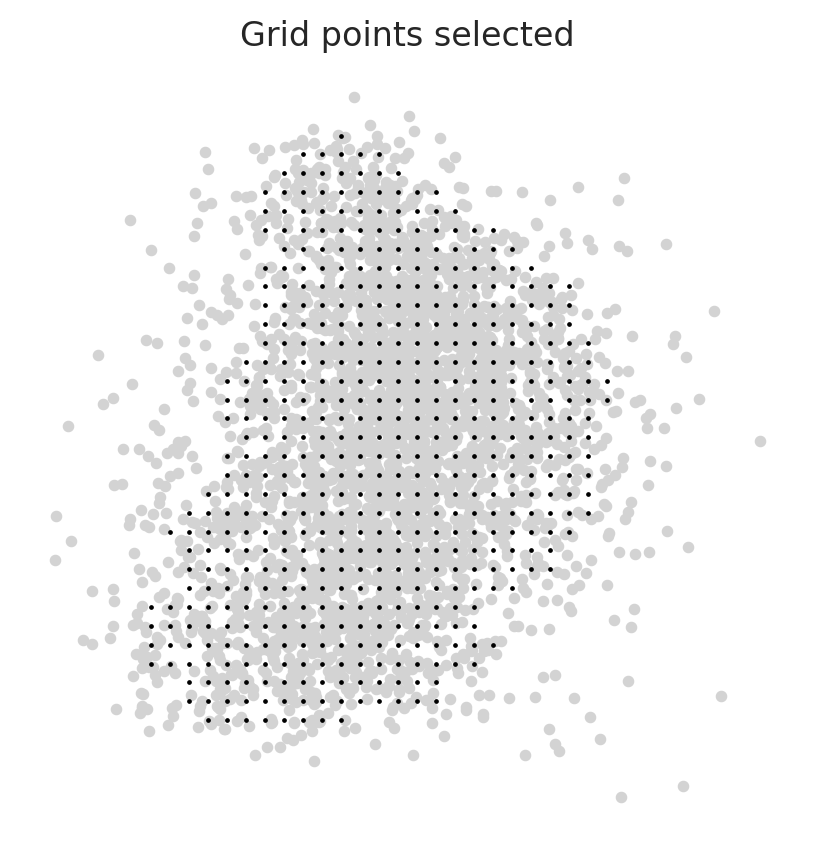

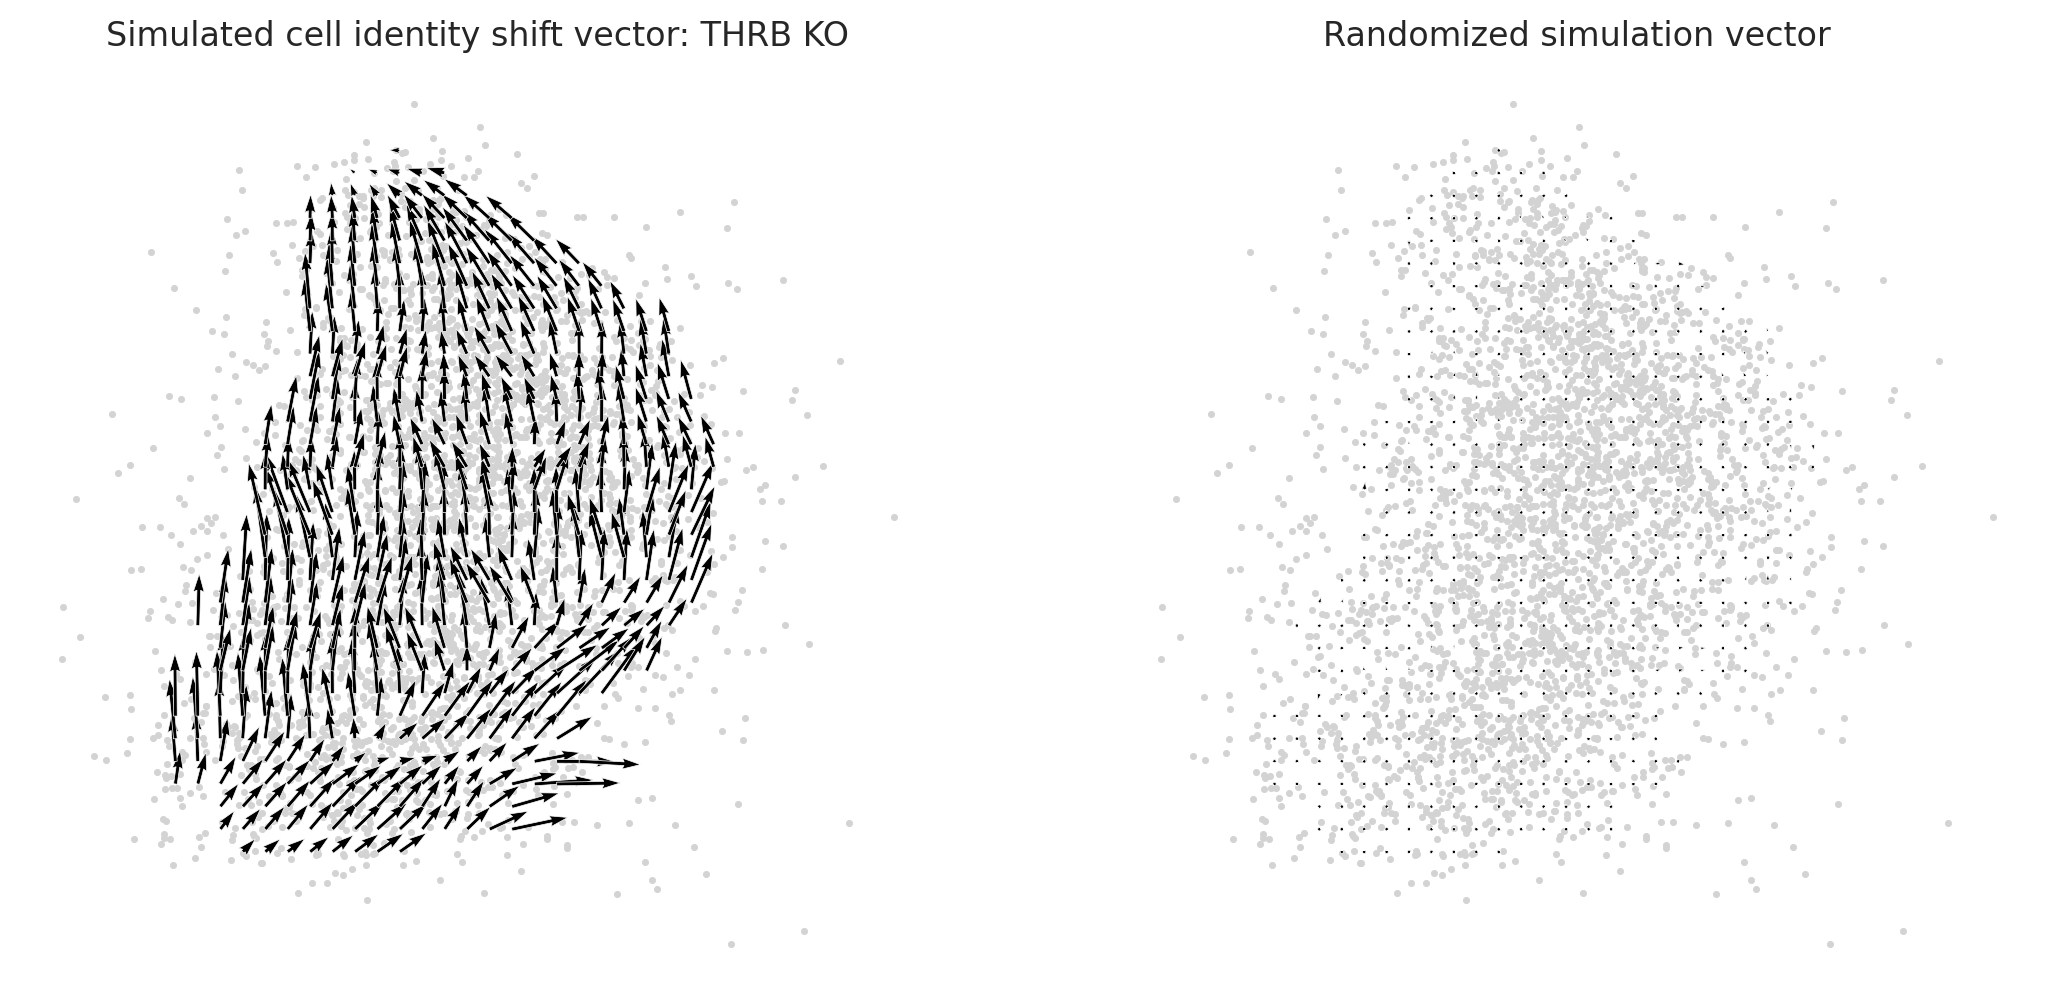

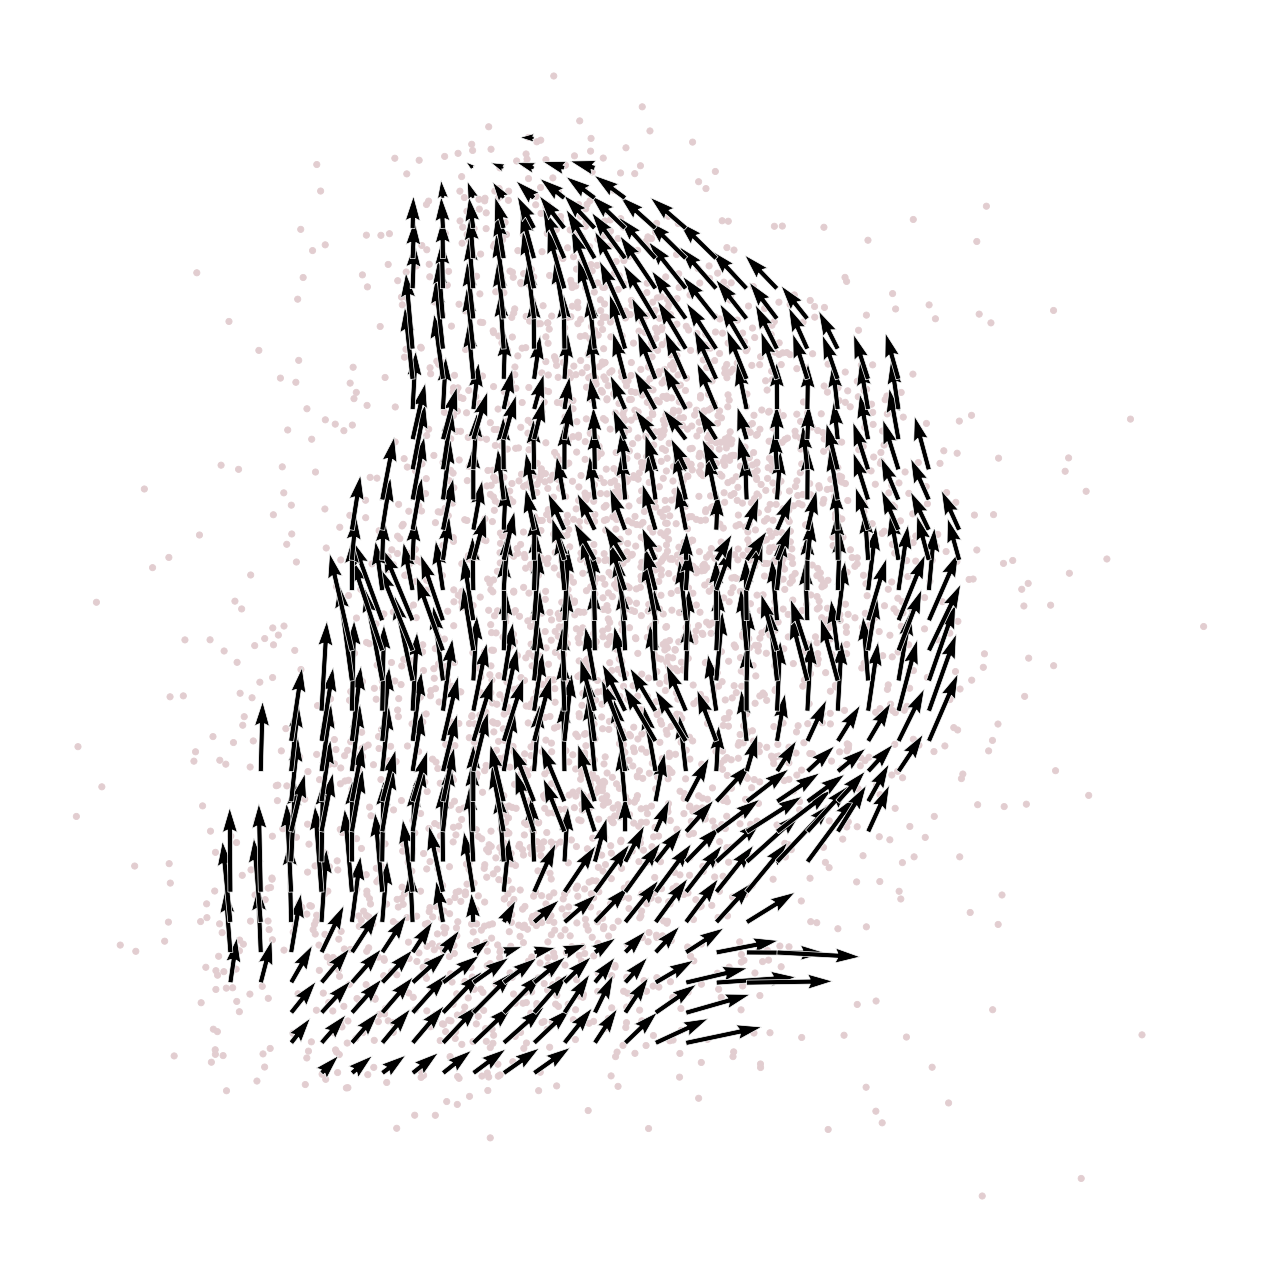

In [ ]:
single_file = True

if single_file:
    all_sim = []
    all_grn = []
# Run simulation for each cell type
for cell_type, oracle in cell_type_oracles.items():
    # Run simulation for each GOI
    for goi in gois:
        if goi in oracle.adata.var_names:
            print(f"{goi} is a regulatory gene in the base GRN for cell type {cell_type}")

            # Plot gene expression
            sc.pl.umap(oracle.adata, color=[goi, oracle.cluster_column_name], layer="imputed_count", use_raw=False, cmap="viridis")
            plt.savefig(os.path.join(output_dir, f"gv2_ene_expression_{goi}_{cell_type}.png"), bbox_inches='tight')
            plt.clf()

            # Run simulation
            oracle.simulate_shift(perturb_condition={goi: 0.0},
                                n_propagation=3)
            oracle.estimate_transition_prob(n_neighbors=200,
                                            knn_random=True,
                                            sampled_fraction=1)
            oracle.calculate_embedding_shift(sigma_corr=0.05)

            # Plot quiver
            fig, ax = plt.subplots(1, 2, figsize=[13, 6])
            scale = 50
            oracle.plot_quiver(scale=scale, ax=ax[0])
            ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")
            oracle.plot_quiver_random(scale=scale, ax=ax[1])
            ax[1].set_title(f"Randomized simulation vector")
            plt.savefig(os.path.join(output_dir, f"v2_quiver_plot_{goi}_{cell_type}.png"), bbox_inches='tight')
            plt.clf()

            # Calculate mass and filter
            n_grid = 40
            oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
            min_mass = 60
            oracle.calculate_mass_filter(min_mass=min_mass, plot=False)
            
            # Plot simulation flow
            fig, ax = plt.subplots(1, 2, figsize=[13, 6])
            scale_simulation = 10
            oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
            ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")
            oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
            ax[1].set_title(f"Randomized simulation vector")
            plt.savefig(os.path.join(output_dir, f"v2_simulation_flow_{goi}_{cell_type}.png"), bbox_inches='tight')
            plt.clf()

            # Plot cluster-specific simulation flow
            fig, ax = plt.subplots(figsize=[8, 8])
            oracle.plot_cluster_whole(ax=ax, s=5)
            oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)
            plt.savefig(os.path.join(output_dir, f"v2_cluster_specific_simulation_flow_{goi}_{cell_type}.png"), bbox_inches='tight')
            plt.clf()

            # Save oracle snapshot for the current GOI and cell type
            # file_name = os.path.join(output_dir, f"v2_Herring_simulation_{goi}_{cell_type}.celloracle.oracle")
            # oracle.to_hdf5(file_name)
            
            # Evaluate perturbation results
            simulated_count = oracle.adata.layers["simulated_count"]
            original_count = oracle.adata.X.toarray()
            log_fold_change = np.log2(simulated_count + 1) - np.log2(original_count + 1)
            
            top_n = 1000
            cell_types = oracle.adata.obs['major_clust']
            gene_names = oracle.adata.var_names
            unique_cell_types = cell_types.unique()
            print(f"unique_cell_types: {unique_cell_types}")
            
            table_data_list = []
            log_fold_change = log_fold_change.mean(axis=0)
            abs_log_fold_change = np.abs(log_fold_change)
            sorted_indices = np.argsort(abs_log_fold_change)[::-1]
            top_gene_indices = sorted_indices[:top_n]
            top_genes = gene_names[top_gene_indices]
            top_log_fold_changes = log_fold_change[top_gene_indices]
            cell_type_table_data = pd.DataFrame({
                'source': [cell_type] * top_n,
                'target': top_genes,
                'log_fold_change': top_log_fold_changes,
            })
            table_data_list.append(cell_type_table_data)
        
            final_table_data_sim = pd.concat(table_data_list, ignore_index=True)
            final_table_data_sim['fold_change'] = np.exp2(final_table_data_sim['log_fold_change'])
            
            if single_file:
                final_table_data_sim['goi'] = goi
                final_table_data_sim['cell_type'] = cell_type
                all_sim.append(final_table_data_sim)
            else:
                final_table_data_sim.to_csv(os.path.join(output_dir, f'v2_scores_sim_{goi}_{cell_type}.csv'), index=False)


            # Get scores from links
            links = oracle.get_links(cluster_name_for_GRN_unit="major_clust", alpha=10, verbose_level=10, n_jobs=n_cpus)
            unique_cell_types = links.filtered_links.unique()
            print(f"unique_cell_types: {unique_cell_types}")
            grn_data = links.filtered_links[unique_cell_types]
            grn_data = grn_data[grn_data["source"] == goi]
            grn_data["score"] = -np.log10(grn_data["p"])
            grn_data["celltype"] = unique_cell_types
            grn_data = grn_data.rename(columns={"-logp": "X.logp"})

            table_data = grn_data[["source", "target", "coef_mean", "coef_abs", "p", "X.logp", "score", "celltype"]]
            if single_file:
                table_data['goi'] = goi
                all_grn.append(table_data)
            else:
                # table_data.to_csv(os.path.join(output_dir, f'v2_scores_grn_{goi}_{cell_type}.csv'), index=False)
        else:
            print(f"{goi} is not a regulatory gene in the base GRN for cell type {cell_type}. Skipping simulation.")      
        
# Concatenate the table data from all cell types into a single DataFrame
if single_file:
    all_sim = pd.concat(all_sim, ignore_index=True)
    # all_sim.to_csv(os.path.join(output_dir, f'v2_scores_sim_all.csv'), index=False)

    # Concatenate all final_table_data DataFrames
    all_grn = pd.concat(all_grn, ignore_index=True)
    # all_grn.to_csv(os.path.join(output_dir, f'v2_scores_grn_all.csv'), index=False)
        
